In [76]:
# Confidence level (e.g., 95%)
confidence_level = 0.95

# Critical value Z
z = stats.norm.ppf((1 + confidence_level) / 2)
z

1.959963984540054

### 1. Import libraries

In [77]:
import os
import pandas as pd
import re

from kedro.pipeline import *
from kedro.io import *
from kedro.runner import *

import pickle
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob


### 2. Read all excels and sheets

In [78]:

import os
import glob
import pandas as pd

# Dossier contenant les fichiers Excel
dossier = r'C:\Users\jrubio\hcl_data\data\01_raw'

# Modèle de fichier Excel que vous recherchez (commençant par "Aiolos")
pattern = 'Aiolos_HCL*.xlsx'

# Créez un dictionnaire pour stocker les DataFrames
dataframes = {}

# Parcourez les fichiers correspondant au modèle
for fichier in glob.glob(os.path.join(dossier, pattern)):
    # Lisez le fichier Excel en tant que dictionnaire de DataFrames (chaque feuille est un DataFrame)
    xls = pd.ExcelFile(fichier)
    
    # Obtenez le nom du fichier sans extension
    nom_fichier = os.path.splitext(os.path.basename(fichier))[0]
    
    # Créez un sous-dictionnaire pour stocker les DataFrames de chaque feuille
    dataframes[nom_fichier] = {}
    
    # Parcourez chaque feuille et stockez-la dans le sous-dictionnaire
    for nom_feuille in xls.sheet_names:
        dataframes[nom_fichier][nom_feuille] = pd.read_excel(fichier, sheet_name=nom_feuille)

excel_file_names = list(dataframes.keys())
excel_file_names


[
    'Aiolos_HCL Lab data_S38 2023_cleaned',
    'Aiolos_HCL Lab data_S39 2023_cleaned',
    'Aiolos_HCL Lab data_S40 2023_cleaned',
    'Aiolos_HCL Lab data_S41 2023_cleaned'
]

### 3. Preprocessing all 

In [79]:
# Initialize lists to store DataFrames for 'Cas_pos' and 'Nb_prélèvement'
cas_pos_dfs = []
nb_prelev_dfs = []

# Iterate through all DataFrames in the 'dataframes' dictionary
for excel_name, excel_df in dataframes.items():
    # Copy the current dictionary keys into a list
    sheet_names = list(excel_df.keys())

    # Iterate through sheet names and rename them by replacing spaces with underscores
    for sheet_name in sheet_names:
        new_sheet_name = sheet_name.replace(' ', '_')
        # Temporarily store the current value under the old key
        sheet_data = excel_df[sheet_name]
        # Remove the old key (sheet name)
        del excel_df[sheet_name]
        # Add a new key with the new sheet name
        excel_df[new_sheet_name] = sheet_data

    # Fetch the DataFrame associated with the "total" sheet and assign it to df_total
    df_total = excel_df["total"]

    # Transpose the DataFrame, switching rows and columns
    df_total = df_total.transpose()
    df_total.reset_index(inplace=True)

    # Set the column names (headers) based on the first row of the DataFrame
    df_total.columns = df_total.iloc[0]

    # Drop the first row as it now contains the column names
    df_total = df_total.iloc[1:]
    
    if "Cas_pos" and "Nb_prélèvement" in excel_df:
        # For the 'Cas_pos' DataFrame
        # Rename the 'Cas pos' column to 'Disease'
        df = excel_df["Cas_pos"].rename(columns={'Cas pos': 'Disease'})
        # Replace spaces with underscores and add 'Cas_Pos_'
        df['Disease'] = 'Cas_Pos_' + df['Disease'].str.replace(' ', '_')
        # Drop the 'Total' column
        df = df.drop(columns=['Total'])
        week_number = df_total["N semaine"].iloc[0]
        # Create a 'Date' column
        df_total['Date'] = pd.to_datetime(df_total['Année'].astype(str) + df_total['N semaine'].astype(str) + '0', format='%Y%W%w')
        df['Date'] = df_total['Date'].values[0]
        # Reshape the data
        df = df.melt(id_vars=['Date', 'Disease'], var_name='Age_class', value_name='Cas_pos')
        df = df.pivot(index=['Date', 'Age_class'], columns='Disease', values='Cas_pos')
        df.reset_index(inplace=True)
        df.columns.name = None
        cas_pos_dfs.append(df)

    if "Nb_prélèvement" in excel_df:
        # For the 'Nb_prélèvement' DataFrame
        # Rename the 'Nb prélèvement' column to 'Disease'
        df = excel_df["Nb_prélèvement"].rename(columns={'Nb prélèvement': 'Disease'})
        # Replace spaces with underscores and add 'Nb_Prelev_'
        df['Disease'] = 'Nb_Prelev_' + df['Disease'].str.replace(' ', '_')
        # Drop the 'Total' column
        df = df.drop(columns=['Total'])
        week_number = df_total["N semaine"].iloc[0]
        # Create a 'Date' column
        df_total['Date'] = pd.to_datetime(df_total['Année'].astype(str) + df_total['N semaine'].astype(str) + '0', format='%Y%W%w')
        df['Date'] = df_total['Date'].values[0]
        
        # Reshape the data
        df = df.melt(id_vars=['Date', 'Disease'], var_name='Age_class', value_name='Nb_prelev')
        df = df.pivot(index=['Date', 'Age_class'], columns='Disease', values='Nb_prelev')
        df.reset_index(inplace=True)
        df.columns.name = None
        nb_prelev_dfs.append(df)

# Concatenate DataFrames for 'Cas_pos'
df_cas_pos = pd.concat(cas_pos_dfs, axis=0, ignore_index=True)

# Concatenate DataFrames for 'Nb_prélèvement'
df_nb_prelev = pd.concat(nb_prelev_dfs, axis=0, ignore_index=True)
df_nb_prelev

,Date,Age_class,Nb_Prelev_Adenovirus,Nb_Prelev_Influenza_(A+B),Nb_Prelev_Metapneumovirus,Nb_Prelev_ParaInfluenza_Virus_(PIV),Nb_Prelev_Picornavirus_(rhinovirus+enterovirus),Nb_Prelev_SARS-Cov-2,Nb_Prelev_VRS
0,2023-09-24,1 à 5,37,43,37,34,34,43,43
1,2023-09-24,11 à 18,14,25,14,14,13,25,25
2,2023-09-24,18 à 40,10,139,10,0,14,139,139
3,2023-09-24,40 à 65,30,226,30,19,39,226,226
4,2023-09-24,6 à 11,21,25,21,17,20,25,25
5,2023-09-24,< 1 an,43,51,43,34,40,51,51
6,2023-09-24,>65 ans,26,569,26,11,26,569,569
7,2023-10-01,1 à 5,30,35,31,27,28,35,35
8,2023-10-01,11 à 18,17,23,17,14,16,23,23
9,2023-10-01,18 à 40,20,186,20,14,24,186,186


In [80]:
date_str = df_total["N semaine"].astype(str).str.extract('(\d+)')[0] + '-' + df_total["Année"].astype(str)
df['Date'] = pd.to_datetime(date_str + '0', format='%W-%Y%w')



In [81]:
# Merge 'df_cas_pos' and 'df_nb_prelev' DataFrames on ['Date', 'Age_class'] with an outer join
merged_df = df_cas_pos.merge(df_nb_prelev, on=["Date", "Age_class"], how='outer')

# Create a translation dictionary for age class labels
age_class_translation = {
    "<1an": "< 1 year",
    "1 à 5": "1 to 5",
    "6 à 11": "6 to 11",
    "11 à 18": "11 to 18",
    "18 à 40": "18 to 40",
    "40 à 65": "40 to 65",
    ">65ans": "> 65 years"
}

# Apply the translation using the .replace() method to update age class labels
merged_df['Age_class'] = merged_df['Age_class'].str.replace(' ', '').str.replace('à', ' à ')
merged_df['Age_class'] = merged_df['Age_class'].replace(age_class_translation)

# Rename the columns dynamically to match the desired format
merged_df = merged_df.rename(columns=lambda x: x.replace("Nb_Prelev_", "Nb_of_test_"))
merged_df = merged_df.rename(columns=lambda x: x.replace("Cas_Pos_", "Pos_test_"))


In [82]:
# Initialize an empty list to store disease names
diseases = []

# Iterate through the columns of the 'merged_df' DataFrame to extract disease names
for column_name in merged_df.columns:
    if column_name.startswith('Pos_test_'):
        disease_name = column_name[len('Pos_test_'):]
        diseases.append(disease_name)

# Initialize the 'fraction_pos_test' DataFrame with columns 'Date' and 'Age_class'
fraction_pos_test = merged_df[['Date', 'Age_class']].copy()

# Iterate through the dynamically extracted disease names and calculate fractions for each disease
for disease in diseases:
    # Calculate the fraction column for this disease by dividing 'Pos_test_xxx' by 'Nb_of_test_xxx'
    cas_pos_column = f'Pos_test_{disease}'
    nb_prelev_column = f'Nb_of_test_{disease}'
    fraction_column = merged_df[cas_pos_column] / merged_df[nb_prelev_column]
    
    # Add this column to the 'fraction_pos_test' DataFrame with a descriptive name
    fraction_pos_test[f'Fraction_Pos_{disease}'] = fraction_column

In [83]:
hcl_lab_final_df = merged_df

# Assuming 'Date' column is in datetime format
hcl_lab_final_df['Month'] = hcl_lab_final_df['Date'].dt.to_period('M')  # Extract the month
baseline_columns = [col for col in hcl_lab_final_df.columns if col.startswith('Pos_test_') or col.startswith('Nb_of_test_')]
baseline_data = hcl_lab_final_df[['Month', 'Age_class'] + baseline_columns]

# Group by both 'Month' and 'Age_class' and calculate the mean
grouped = baseline_data.groupby(['Month', 'Age_class'])

# Use the aggregate method to calculate the mean
agg_result = grouped.mean().reset_index()

# Add the suffix "_BASELINE" to the column names
agg_result.columns = [col + '_BASELINE' if col in baseline_columns else col for col in agg_result.columns]

# Merge the mean based on 'Month' and 'Age_class' with the original DataFrame
hcl_lab_final_df = hcl_lab_final_df.merge(agg_result, on=['Month', 'Age_class'], how='left')
hcl_lab_final_df = hcl_lab_final_df.drop("Month", axis=1)

In [86]:
subset = hcl_lab_final_df[hcl_lab_final_df['Age_class'] == "> 65 years"]
subset

,Date,Age_class,Pos_test_Adenovirus,Pos_test_Influenza_(A+B),Pos_test_Metapneumovirus,Pos_test_ParaInfluenza_Virus_(PIV),Pos_test_Picornavirus_(rhinovirus+enterovirus),Pos_test_SARS-Cov-2,Pos_test_VRS,Nb_of_test_Adenovirus,...,Pos_test_Picornavirus_(rhinovirus+enterovirus)_BASELINE,Pos_test_SARS-Cov-2_BASELINE,Pos_test_VRS_BASELINE,Nb_of_test_Adenovirus_BASELINE,Nb_of_test_Influenza_(A+B)_BASELINE,Nb_of_test_Metapneumovirus_BASELINE,Nb_of_test_ParaInfluenza_Virus_(PIV)_BASELINE,Nb_of_test_Picornavirus_(rhinovirus+enterovirus)_BASELINE,Nb_of_test_SARS-Cov-2_BASELINE,Nb_of_test_VRS_BASELINE
6,2023-09-24,> 65 years,0,0,0,0,4,109,0,26,...,4.000000,109.0,0.0,26.000000,569.000000,26.000000,11.000000,26.0,569.000000,569.000000
13,2023-10-01,> 65 years,0,0,0,0,3,120,0,33,...,3.666667,124.0,0.0,45.333333,616.666667,40.333333,16.666667,45.0,617.666667,429.333333
20,2023-10-08,> 65 years,0,0,0,0,3,119,0,48,...,3.666667,124.0,0.0,45.333333,616.666667,40.333333,16.666667,45.0,617.666667,429.333333
27,2023-10-15,> 65 years,0,5,0,0,5,133,0,55,...,3.666667,124.0,0.0,45.333333,616.666667,40.333333,16.666667,45.0,617.666667,429.333333


In [92]:
col = "Pos_test_Picornavirus_(rhinovirus+enterovirus)_BASELINE"
lower_col = 'LOWER_CI_' + col
upper_col = 'UPPER_CI_' + col

subset[lower_col] = np.nan
subset[upper_col] = np.nan

std_dev = subset[col].std()

lower_ci = subset[col] - z * std_dev
upper_ci = subset[col] + z * std_dev

        # Ensure that LOWER_CI is not less than zero
#hcl_lab_final_df.loc[hcl_lab_final_df['Age_class'] == age_class, lower_col] = lower_ci.clip(lower=0)
#hcl_lab_final_df.loc[hcl_lab_final_df['Age_class'] == age_class, upper_col] = upper_ci.clip(lower=0)

upper_ci

[11/15/23 14:07:25] WARNING  C:\Users\jrubio\AppData\Local\Temp\ipykernel_23536\947633807.py:5:     ]8;id=591285;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=82103;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               subset[lower_col] = np.nan                                                          
                                                                                                                   

                    WARNING  C:\Users\jrubio\AppData\Local\Temp\ipykernel_23536\947633807.py:6:     ]8;id=613449;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py\warnings.py]8;;\:]8;id=400517;file://c:\ProgramData\Anaconda3\envs\kedro-environment\lib\warnings.py#109\109]8;;\
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame.                    
                             Try using .loc[row_indexer,col_indexer] = value instead                               
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               subset[upper_col] = np.nan                                                          
                                                                                                                   


6     4.326661
13    3.993327
20    3.993327
27    3.993327
Name: Pos_test_Picornavirus_(rhinovirus+enterovirus)_BASELINE, dtype: float64

In [72]:


from scipy import stats

# Define the confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the critical value using the normal distribution
z = stats.norm.ppf((1 + confidence_level) / 2)

# Columns to calculate confidence intervals for (specify your baseline columns)
baseline_columns = [col for col in hcl_lab_final_df.columns if col.endswith('_BASELINE')]

# Create new columns to store the results
for col in baseline_columns:
    lower_col = 'LOWER_CI_' + col
    upper_col = 'UPPER_CI_' + col

    # Initialize columns with NaN
    hcl_lab_final_df[lower_col] = np.nan
    hcl_lab_final_df[upper_col] = np.nan

    # Calculate confidence intervals for each baseline column
    for age_class in hcl_lab_final_df['Age_class'].unique():
        # Select rows for the specific Age_Class
        subset = hcl_lab_final_df[hcl_lab_final_df['Age_class'] == age_class]

        # Calculate the standard deviation for the specific column
        std_dev = subset[col].std()

        lower_ci = subset[col] - z * std_dev
        upper_ci = subset[col] + z * std_dev

        # Ensure that LOWER_CI is not less than zero
        hcl_lab_final_df.loc[hcl_lab_final_df['Age_class'] == age_class, lower_col] = lower_ci.clip(lower=0)
        hcl_lab_final_df.loc[hcl_lab_final_df['Age_class'] == age_class, upper_col] = upper_ci.clip(lower=0)
        
hcl_lab_final_df

,Date,Pos_test_SARS-Cov-2,Nb_of_test_SARS-Cov-2,Pos_test_SARS-Cov-2_BASELINE,Nb_of_test_SARS-Cov-2_BASELINE
0,2023-09-24,4,43,4.0,43.0
1,2023-09-24,0,25,0.0,25.0
2,2023-09-24,27,139,27.0,139.0
3,2023-09-24,34,226,34.0,226.0
4,2023-09-24,2,25,2.0,25.0
5,2023-09-24,13,51,13.0,51.0
6,2023-09-24,109,569,109.0,569.0
7,2023-10-01,3,35,3.0,35.0
8,2023-10-01,0,23,0.0,23.0
9,2023-10-01,37,186,37.0,186.0


In [ ]:
from scipy import stats

# Define the confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the critical value using the normal distribution
z = stats.norm.ppf((1 + confidence_level) / 2)

# Columns to calculate confidence intervals for (specify your baseline columns)
baseline_columns = [col for col in hcl_lab_final_df.columns if col.endswith('_BASELINE')]

# Create new columns to store the results
for col in baseline_columns:
    lower_col = 'LOWER_CI_' + col
    upper_col = 'UPPER_CI_' + col

    # Initialize columns with NaN
    hcl_lab_final_df[lower_col] = np.nan
    hcl_lab_final_df[upper_col] = np.nan

    # Calculate confidence intervals for each baseline column
    for age_class in hcl_lab_final_df['Age_class'].unique():
        # Select rows for the specific Age_Class
        subset = hcl_lab_final_df[hcl_lab_final_df['Age_class'] == age_class]

        # Calculate the standard deviation for the specific column
        std_dev = subset[col].std()

        lower_ci = subset[col] - z * std_dev
        upper_ci = subset[col] + z * std_dev

        # Ensure that LOWER_CI is not less than zero
        hcl_lab_final_df.loc[hcl_lab_final_df['Age_class'] == age_class, lower_col] = lower_ci.clip(lower=0)
        hcl_lab_final_df.loc[hcl_lab_final_df['Age_class'] == age_class, upper_col] = upper_ci.clip(lower=0)
        
hcl_lab_final_df

In [ ]:
# Initialize an empty list to store disease names
diseases = []

# Iterate through the columns of the 'merged_df' DataFrame to extract disease names
for column_name in result_df.columns:
    if column_name.startswith('Pos_test_') and column_name.endswith('_NOWCASTING'):
        disease_name = column_name[len('Pos_test_'):-len('_NOWCASTING')]
        diseases.append(disease_name)

# Initialize the 'fraction_pos_test' DataFrame with columns 'Date' and 'Age_class'
fraction_pos_test = result_df[['Date', 'Age_class']].copy()

# Iterate through the dynamically extracted disease names and calculate fractions for each disease
for disease in diseases:
    # Calculate the fraction column for this disease by dividing 'Pos_test_xxx' by 'Nb_of_test_xxx'
    cas_pos_column = f'Pos_test_{disease}_NOWCASTING'
    nb_prelev_column = f'Nb_of_test_{disease}_NOWCASTING'
    fraction_column = result_df[cas_pos_column] / result_df[nb_prelev_column]
    
    # Add this column to the 'fraction_pos_test' DataFrame with a descriptive name
    fraction_pos_test[f'Fraction_Pos_test_{disease}_NOWCASTING'] = fraction_column

In [10]:
df = pd.DataFrame(hcl_lab_final_df)
chemin_fichier = "C:\\Users\\jrubio\\hcl_data\\data\\07_model_output\\hcl_lab_final_df.csv"
df.to_csv(chemin_fichier)

In [11]:
import numpy as np
import pandas as pd
from scipy import stats


# Define the correction factors (you can replace this with your correction_factor_last_weeks)
correction_factor_last_weeks = np.linspace(1, 0.5, 12 + 1)[::-1]

# List of columns to apply nowcasting to
columns_to_nowcast = [col for col in merged_df.columns if col.startswith("Pos_test_") or col.startswith("Nb_of_test_")]

# Create an empty DataFrame to store the results
result_df = pd.DataFrame()

# Iterate over each unique Age_class
for age_class in merged_df["Age_class"].unique():
    mask = (merged_df['Age_class'] == age_class)
    df = merged_df[["Date", "Age_class"] + columns_to_nowcast].loc[mask]
    df = df.sort_values(by='Date', ascending=False)
    df["correction_factor"] = correction_factor_last_weeks[:len(df)]
    
    # Define a function to apply the correction factor to each column
    def apply_correction(col):
        return col / df["correction_factor"]
    
    # Apply the correction function to each column to calculate the nowcasted values
    for col in columns_to_nowcast:
        col_nowcasted = col + "_NOWCASTING"
        df[col_nowcasted] = apply_correction(df[col])
    
    result_df = pd.concat([result_df, df], ignore_index=True)  # Use concat to combine DataFrames

# Define the confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the critical value using the normal distribution
z = stats.norm.ppf((1 + confidence_level) / 2)

# Columns to calculate confidence intervals for
baseline_columns = [col for col in result_df.columns if col.endswith('_NOWCASTING')]

# Calculate confidence intervals for each baseline column
for col in baseline_columns:
    lower_col = 'LOWER_CI_' + col
    upper_col = 'UPPER_CI_' + col
    
    lower_ci = result_df[col] - z * result_df[col].apply(lambda x: max(x, 0))
    upper_ci = result_df[col] + z * result_df[col].apply(lambda x: max(x, 0))
    
    # Ensure that LOWER_CI is not less than zero
    result_df[lower_col] = lower_ci.apply(lambda x: max(x, 0))
    result_df[upper_col] = upper_ci

result_df

,Date,Age_class,Pos_test_Adenovirus,Pos_test_Influenza_(A+B),Pos_test_Metapneumovirus,Pos_test_ParaInfluenza_Virus_(PIV),Pos_test_Picornavirus_(rhinovirus+enterovirus),Pos_test_SARS-Cov-2,Pos_test_VRS,Nb_of_test_Adenovirus,...,LOWER_CI_Nb_of_test_Metapneumovirus_NOWCASTING,UPPER_CI_Nb_of_test_Metapneumovirus_NOWCASTING,LOWER_CI_Nb_of_test_ParaInfluenza_Virus_(PIV)_NOWCASTING,UPPER_CI_Nb_of_test_ParaInfluenza_Virus_(PIV)_NOWCASTING,LOWER_CI_Nb_of_test_Picornavirus_(rhinovirus+enterovirus)_NOWCASTING,UPPER_CI_Nb_of_test_Picornavirus_(rhinovirus+enterovirus)_NOWCASTING,LOWER_CI_Nb_of_test_SARS-Cov-2_NOWCASTING,UPPER_CI_Nb_of_test_SARS-Cov-2_NOWCASTING,LOWER_CI_Nb_of_test_VRS_NOWCASTING,UPPER_CI_Nb_of_test_VRS_NOWCASTING
0,2023-10-01,1 to 5,0,0,0,0,15,3,0,30,...,0,183.517767,0.0,159.838055,0,165.757983,0,207.197479,0,207.197479
1,2023-09-24,1 to 5,2,0,0,0,20,4,0,37,...,0,202.188309,0.0,185.794662,0,185.794662,0,234.975602,0,234.975602
2,2023-10-01,11 to 18,0,0,0,0,4,0,0,17,...,0,100.638775,0.0,82.878992,0,94.718848,0,136.158343,0,136.158343
3,2023-09-24,11 to 18,0,0,0,0,4,0,0,14,...,0,76.503685,0.0,76.503685,0,71.039136,0,136.613722,0,136.613722
4,2023-10-01,18 to 40,0,3,0,0,4,37,0,20,...,0,118.398559,0.0,82.878992,0,142.078271,0,1101.106602,0,1101.106602
5,2023-09-24,18 to 40,0,2,0,0,3,27,0,10,...,0,54.645489,0.0,0.000000,0,76.503685,0,759.572296,0,759.572296
6,2023-10-01,40 to 65,0,0,0,0,2,43,0,27,...,0,159.838055,0.0,100.638775,0,159.838055,0,1497.741776,0,1497.741776
7,2023-09-24,40 to 65,0,0,0,0,2,34,0,30,...,0,163.936467,0.0,103.826429,0,213.117407,0,1234.988050,0,1234.988050
8,2023-10-01,6 to 11,0,0,0,0,8,0,0,18,...,0,106.558703,0.0,59.199280,0,106.558703,0,118.398559,0,118.398559
9,2023-09-24,6 to 11,0,0,0,0,13,2,0,21,...,0,114.755527,0.0,92.897331,0,109.290978,0,136.613722,0,136.613722


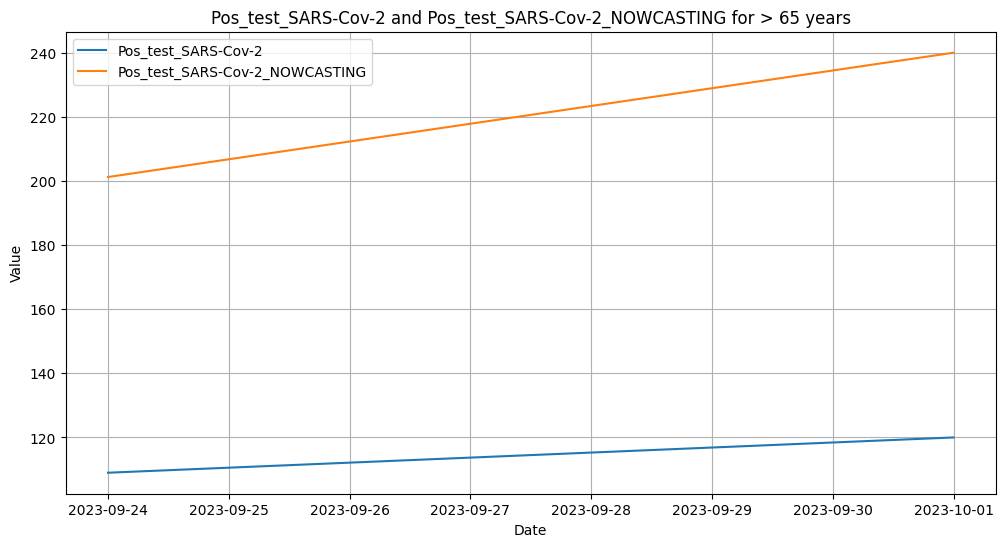

In [12]:
import matplotlib.pyplot as plt

# Filter the DataFrame for the specified age class
age_class = "> 65 years"
filtered_df = result_df[result_df["Age_class"] == age_class]

# Select the column of interest (e.g., Pos_test_SARS-Cov-2)
column_name = "Pos_test_SARS-Cov-2"
nowcasted_column_name = column_name + "_NOWCASTING"

# Plot the original and nowcasted values
plt.figure(figsize=(12, 6))
plt.plot(filtered_df["Date"], filtered_df[column_name], label=column_name)
plt.plot(filtered_df["Date"], filtered_df[nowcasted_column_name], label=nowcasted_column_name)

# Customize the plot
plt.title(f"{column_name} and {nowcasted_column_name} for {age_class}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [13]:
result_df

,Date,Age_class,Pos_test_Adenovirus,Pos_test_Influenza_(A+B),Pos_test_Metapneumovirus,Pos_test_ParaInfluenza_Virus_(PIV),Pos_test_Picornavirus_(rhinovirus+enterovirus),Pos_test_SARS-Cov-2,Pos_test_VRS,Nb_of_test_Adenovirus,...,LOWER_CI_Nb_of_test_Metapneumovirus_NOWCASTING,UPPER_CI_Nb_of_test_Metapneumovirus_NOWCASTING,LOWER_CI_Nb_of_test_ParaInfluenza_Virus_(PIV)_NOWCASTING,UPPER_CI_Nb_of_test_ParaInfluenza_Virus_(PIV)_NOWCASTING,LOWER_CI_Nb_of_test_Picornavirus_(rhinovirus+enterovirus)_NOWCASTING,UPPER_CI_Nb_of_test_Picornavirus_(rhinovirus+enterovirus)_NOWCASTING,LOWER_CI_Nb_of_test_SARS-Cov-2_NOWCASTING,UPPER_CI_Nb_of_test_SARS-Cov-2_NOWCASTING,LOWER_CI_Nb_of_test_VRS_NOWCASTING,UPPER_CI_Nb_of_test_VRS_NOWCASTING
0,2023-10-01,1 to 5,0,0,0,0,15,3,0,30,...,0,183.517767,0.0,159.838055,0,165.757983,0,207.197479,0,207.197479
1,2023-09-24,1 to 5,2,0,0,0,20,4,0,37,...,0,202.188309,0.0,185.794662,0,185.794662,0,234.975602,0,234.975602
2,2023-10-01,11 to 18,0,0,0,0,4,0,0,17,...,0,100.638775,0.0,82.878992,0,94.718848,0,136.158343,0,136.158343
3,2023-09-24,11 to 18,0,0,0,0,4,0,0,14,...,0,76.503685,0.0,76.503685,0,71.039136,0,136.613722,0,136.613722
4,2023-10-01,18 to 40,0,3,0,0,4,37,0,20,...,0,118.398559,0.0,82.878992,0,142.078271,0,1101.106602,0,1101.106602
5,2023-09-24,18 to 40,0,2,0,0,3,27,0,10,...,0,54.645489,0.0,0.000000,0,76.503685,0,759.572296,0,759.572296
6,2023-10-01,40 to 65,0,0,0,0,2,43,0,27,...,0,159.838055,0.0,100.638775,0,159.838055,0,1497.741776,0,1497.741776
7,2023-09-24,40 to 65,0,0,0,0,2,34,0,30,...,0,163.936467,0.0,103.826429,0,213.117407,0,1234.988050,0,1234.988050
8,2023-10-01,6 to 11,0,0,0,0,8,0,0,18,...,0,106.558703,0.0,59.199280,0,106.558703,0,118.398559,0,118.398559
9,2023-09-24,6 to 11,0,0,0,0,13,2,0,21,...,0,114.755527,0.0,92.897331,0,109.290978,0,136.613722,0,136.613722


In [19]:
# Initialize an empty list to store disease names
diseases = []

# Iterate through the columns of the 'merged_df' DataFrame to extract disease names
for column_name in result_df.columns:
    if column_name.startswith('Pos_test_') and column_name.endswith('_NOWCASTING'):
        disease_name = column_name[len('Pos_test_'):-len('_NOWCASTING')]
        diseases.append(disease_name)

# Initialize the 'fraction_pos_test' DataFrame with columns 'Date' and 'Age_class'
fraction_pos_test = result_df[['Date', 'Age_class']].copy()

# Iterate through the dynamically extracted disease names and calculate fractions for each disease
for disease in diseases:
    # Calculate the fraction column for this disease by dividing 'Pos_test_xxx' by 'Nb_of_test_xxx'
    cas_pos_column = f'Pos_test_{disease}_NOWCASTING'
    nb_prelev_column = f'Nb_of_test_{disease}_NOWCASTING'
    fraction_column = result_df[cas_pos_column] / result_df[nb_prelev_column]
    
    # Add this column to the 'fraction_pos_test' DataFrame with a descriptive name
    fraction_pos_test[f'Fraction_Pos_test_{disease}_NOWCASTING'] = fraction_column

In [18]:
result_df.columns


Index(['Date', 'Age_class', 'Pos_test_Adenovirus', 'Pos_test_Influenza_(A+B)',
       'Pos_test_Metapneumovirus', 'Pos_test_ParaInfluenza_Virus_(PIV)',
       'Pos_test_Picornavirus_(rhinovirus+enterovirus)', 'Pos_test_SARS-Cov-2',
       'Pos_test_VRS', 'Nb_of_test_Adenovirus', 'Nb_of_test_Influenza_(A+B)',
       'Nb_of_test_Metapneumovirus', 'Nb_of_test_ParaInfluenza_Virus_(PIV)',
       'Nb_of_test_Picornavirus_(rhinovirus+enterovirus)',
       'Nb_of_test_SARS-Cov-2', 'Nb_of_test_VRS', 'correction_factor',
       'Pos_test_Adenovirus_NOWCASTING', 'Pos_test_Influenza_(A+B)_NOWCASTING',
       'Pos_test_Metapneumovirus_NOWCASTING',
       'Pos_test_ParaInfluenza_Virus_(PIV)_NOWCASTING',
       'Pos_test_Picornavirus_(rhinovirus+enterovirus)_NOWCASTING',
       'Pos_test_SARS-Cov-2_NOWCASTING', 'Pos_test_VRS_NOWCASTING',
       'Nb_of_test_Adenovirus_NOWCASTING',
       'Nb_of_test_Influenza_(A+B)_NOWCASTING',
       'Nb_of_test_Metapneumovirus_NOWCASTING',
       'Nb_of_test_ParaIn

In [25]:
result_df[["Date","Age_class","Pos_test_Metapneumovirus",'Pos_test_Metapneumovirus_NOWCASTING','Nb_of_test_Metapneumovirus','Nb_of_test_Metapneumovirus_NOWCASTING']]

,Date,Age_class,Pos_test_Metapneumovirus,Pos_test_Metapneumovirus_NOWCASTING,Nb_of_test_Metapneumovirus,Nb_of_test_Metapneumovirus_NOWCASTING
0,2023-10-01,1 to 5,0,0.0,31,62.000000
1,2023-09-24,1 to 5,0,0.0,37,68.307692
2,2023-10-01,11 to 18,0,0.0,17,34.000000
3,2023-09-24,11 to 18,0,0.0,14,25.846154
4,2023-10-01,18 to 40,0,0.0,20,40.000000
5,2023-09-24,18 to 40,0,0.0,10,18.461538
6,2023-10-01,40 to 65,0,0.0,27,54.000000
7,2023-09-24,40 to 65,0,0.0,30,55.384615
8,2023-10-01,6 to 11,0,0.0,18,36.000000
9,2023-09-24,6 to 11,0,0.0,21,38.769231


In [20]:
fraction_pos_test

,Date,Age_class,Fraction_Pos_test_Adenovirus_NOWCASTING,Fraction_Pos_test_Influenza_(A+B)_NOWCASTING,Fraction_Pos_test_Metapneumovirus_NOWCASTING,Fraction_Pos_test_ParaInfluenza_Virus_(PIV)_NOWCASTING,Fraction_Pos_test_Picornavirus_(rhinovirus+enterovirus)_NOWCASTING,Fraction_Pos_test_SARS-Cov-2_NOWCASTING,Fraction_Pos_test_VRS_NOWCASTING
0,2023-10-01,1 to 5,0.000000,0.000000,0.0,0.0,0.535714,0.085714,0.0
1,2023-09-24,1 to 5,0.054054,0.000000,0.0,0.0,0.588235,0.093023,0.0
2,2023-10-01,11 to 18,0.000000,0.000000,0.0,0.0,0.250000,0.000000,0.0
3,2023-09-24,11 to 18,0.000000,0.000000,0.0,0.0,0.307692,0.000000,0.0
4,2023-10-01,18 to 40,0.000000,0.016129,0.0,0.0,0.166667,0.198925,0.0
5,2023-09-24,18 to 40,0.000000,0.014388,0.0,NaN,0.214286,0.194245,0.0
6,2023-10-01,40 to 65,0.000000,0.000000,0.0,0.0,0.074074,0.169960,0.0
7,2023-09-24,40 to 65,0.000000,0.000000,0.0,0.0,0.051282,0.150442,0.0
8,2023-10-01,6 to 11,0.000000,0.000000,0.0,0.0,0.444444,0.000000,0.0
9,2023-09-24,6 to 11,0.000000,0.000000,0.0,0.0,0.650000,0.080000,0.0


In [96]:

import os
import pandas as pd
import re

from kedro.pipeline import *
from kedro.io import *
from kedro.runner import *

import pickle
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


chemin_fichier_csv = "C:/Users/jrubio/hcl_data/data/04_feature/hcl_lab_baseline_final.csv"
df = pd.read_csv(chemin_fichier_csv)



In [99]:
confidence_level = 0.95
z = stats.norm.ppf((1 + confidence_level) / 2)
z

1.959963984540054

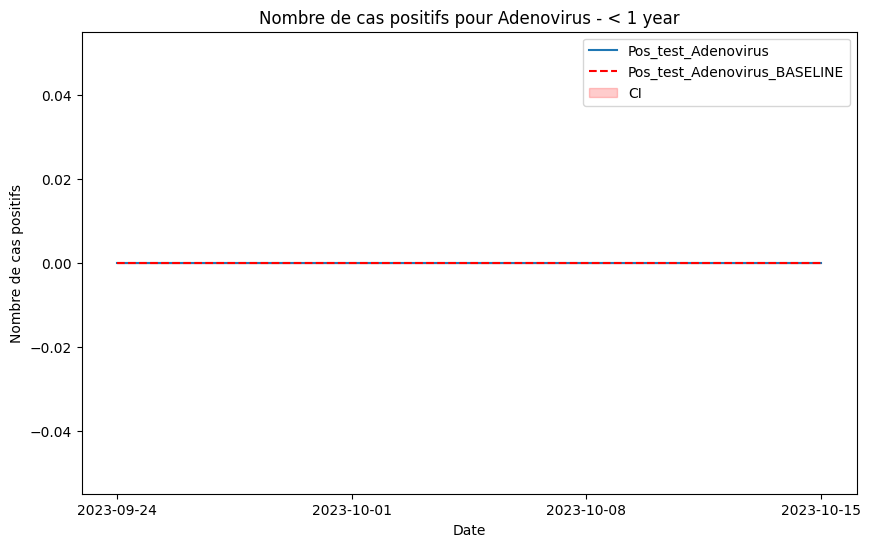

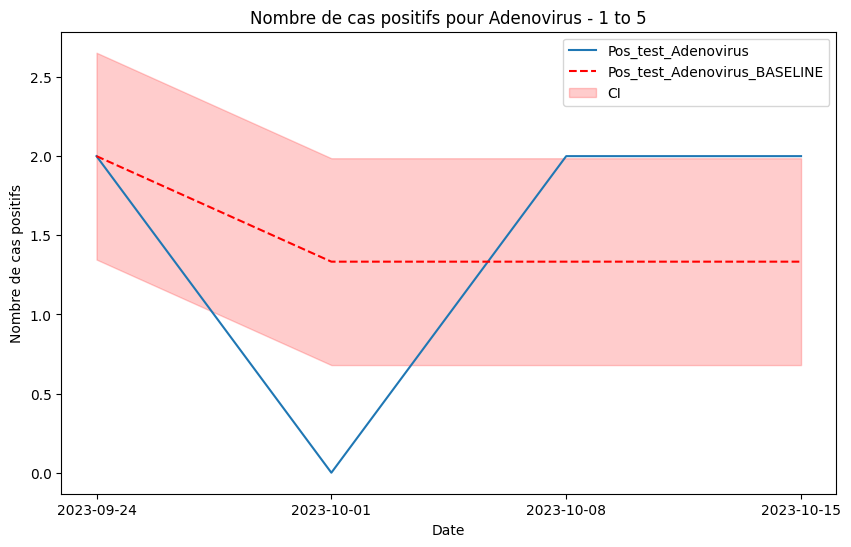

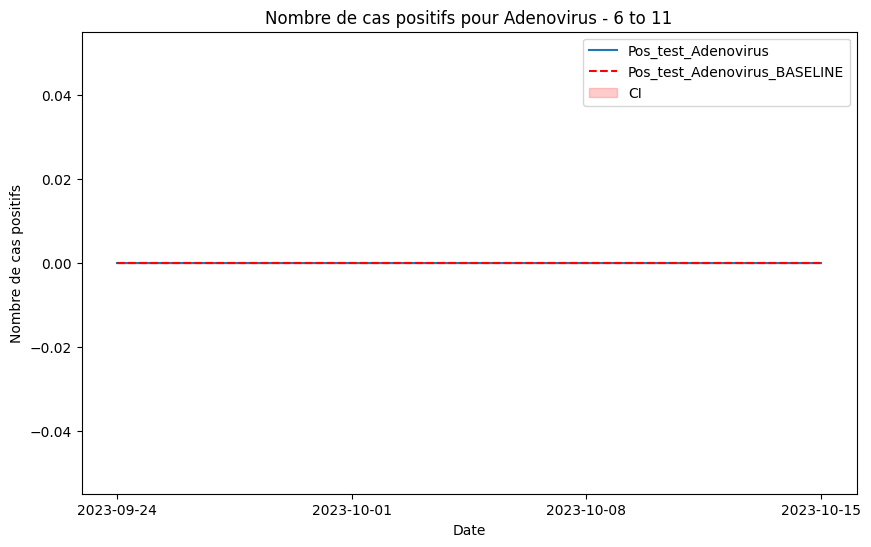

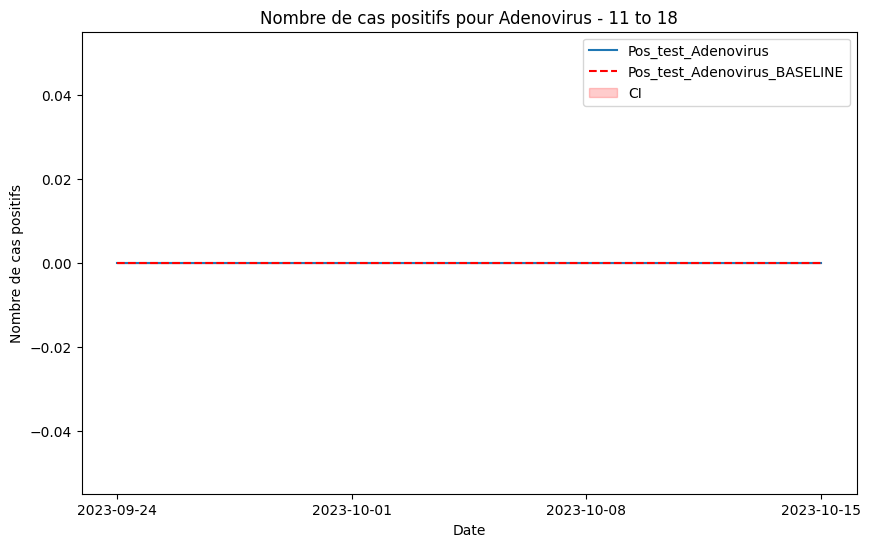

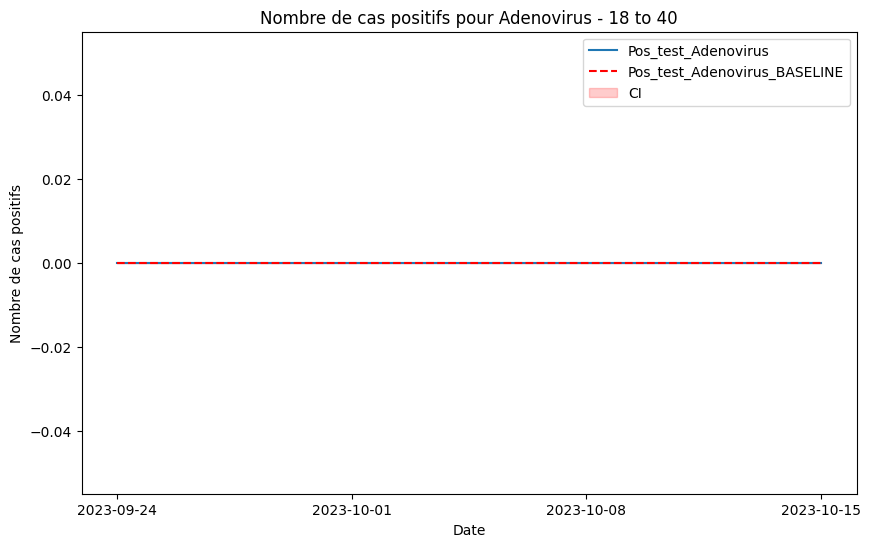

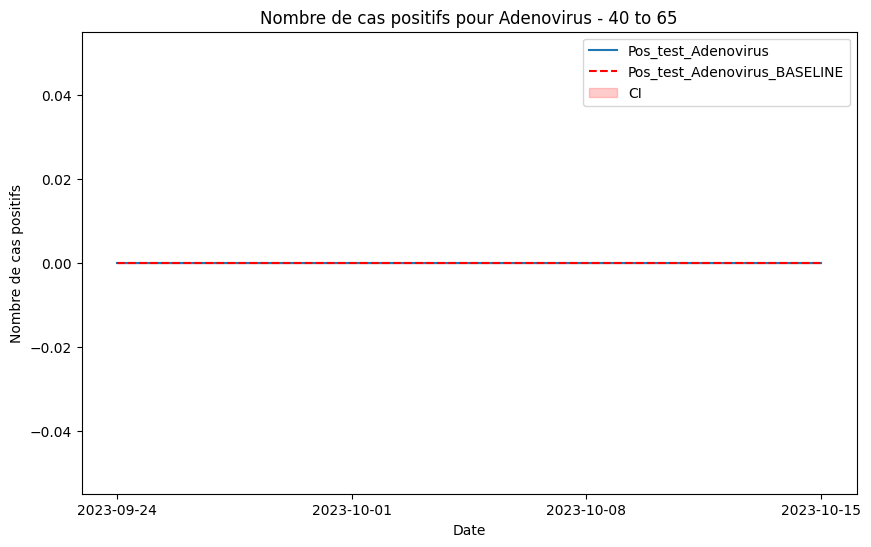

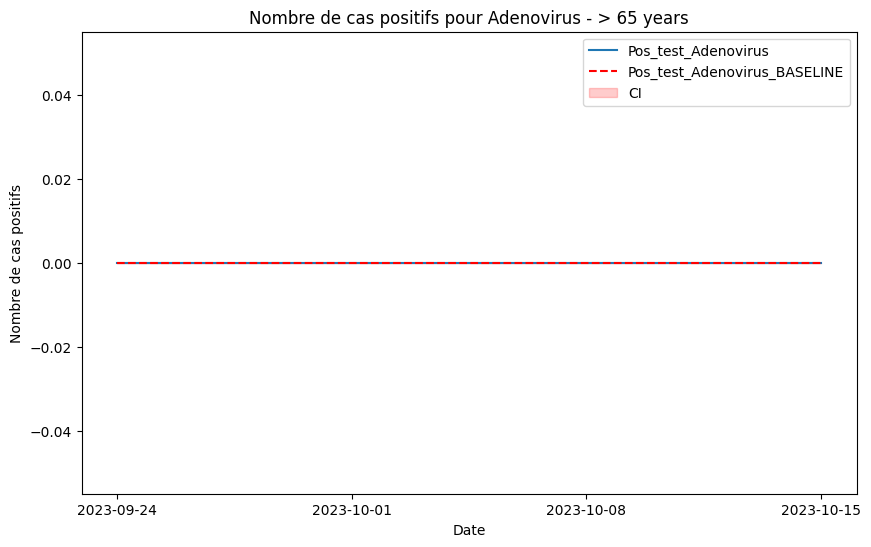

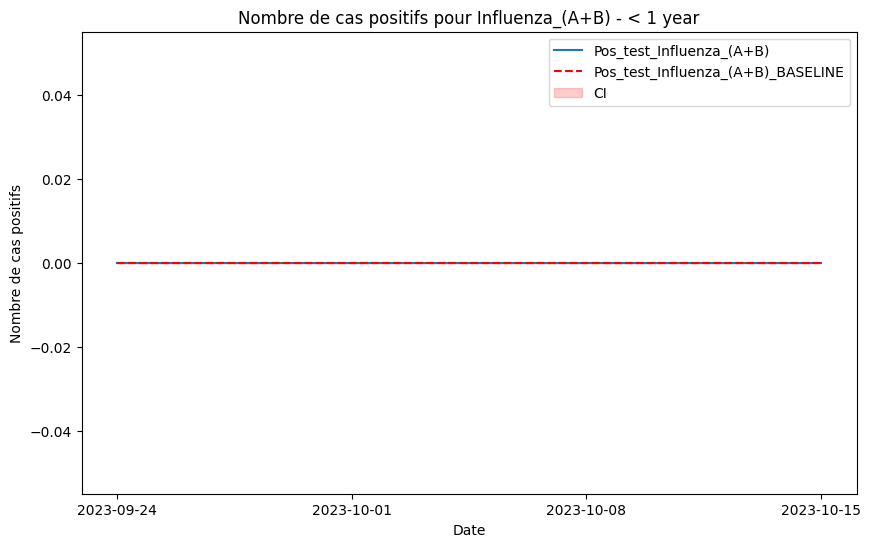

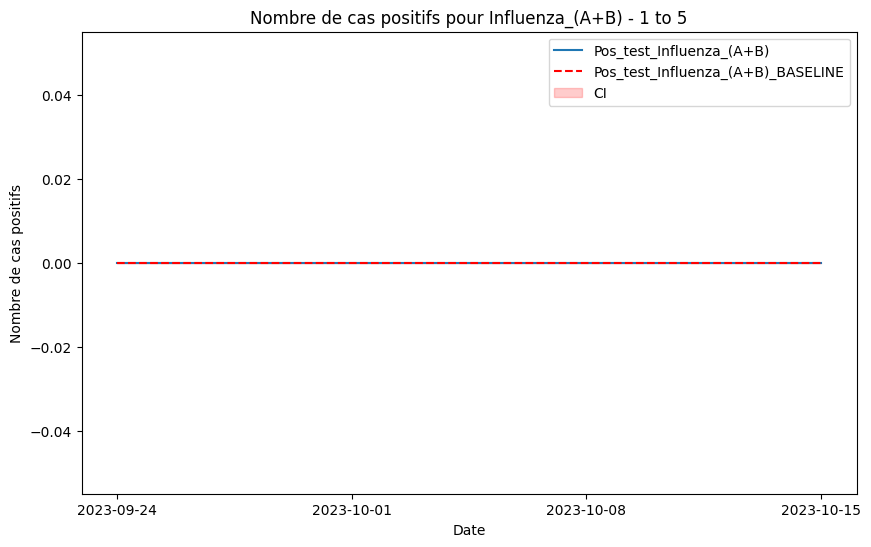

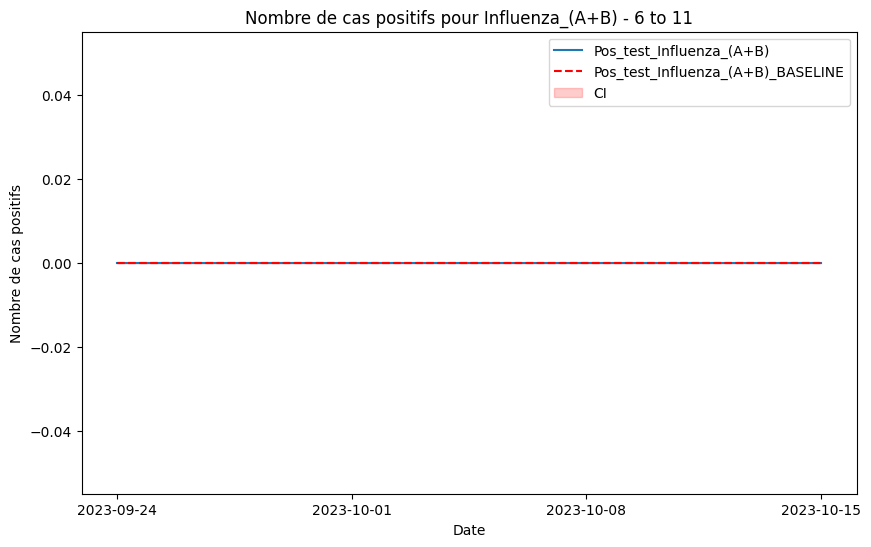

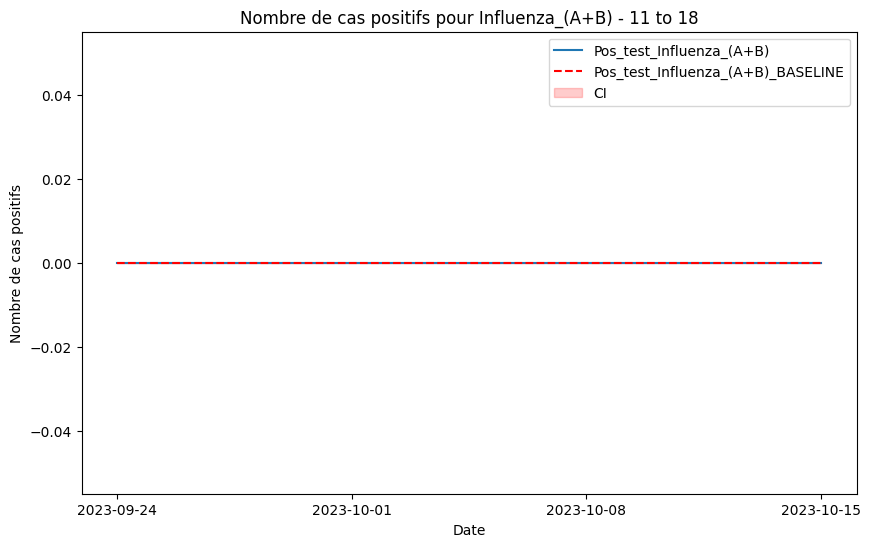

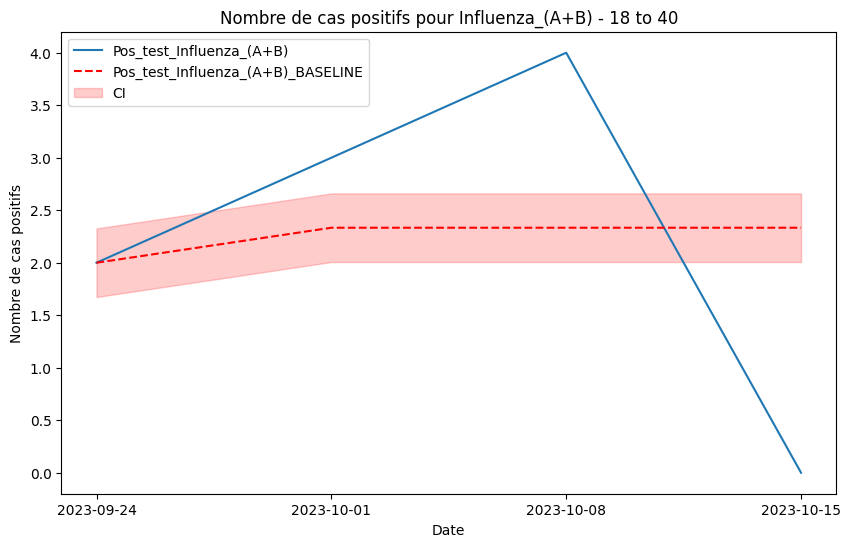

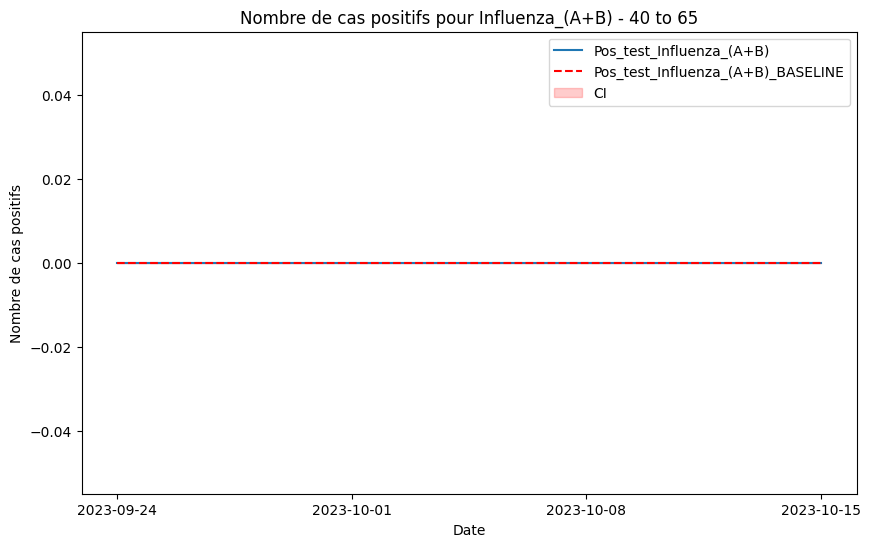

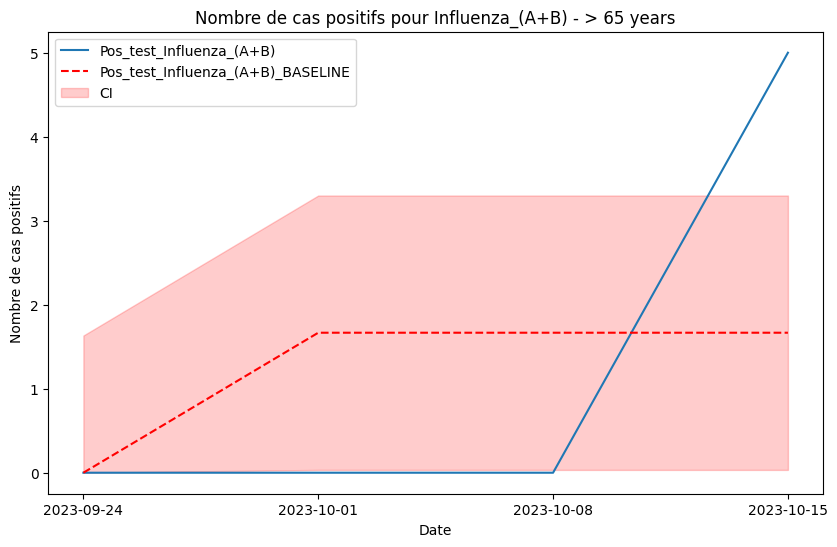

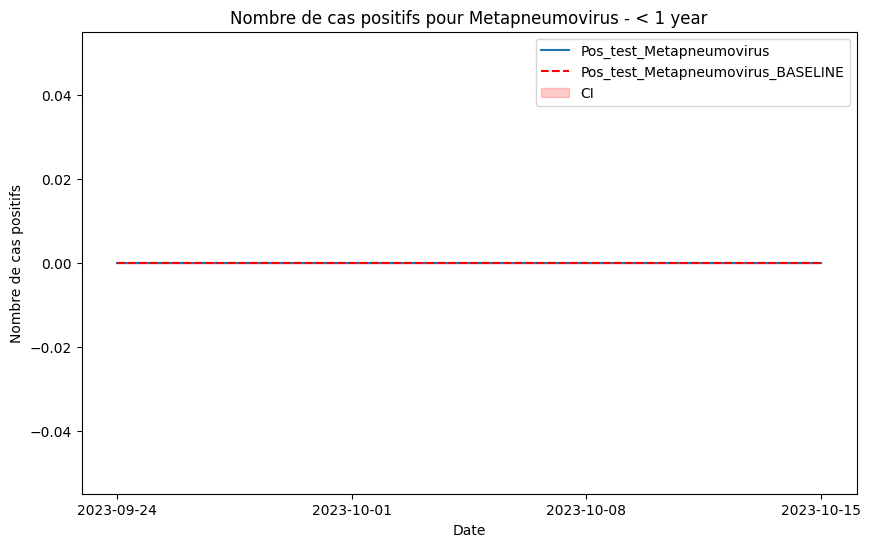

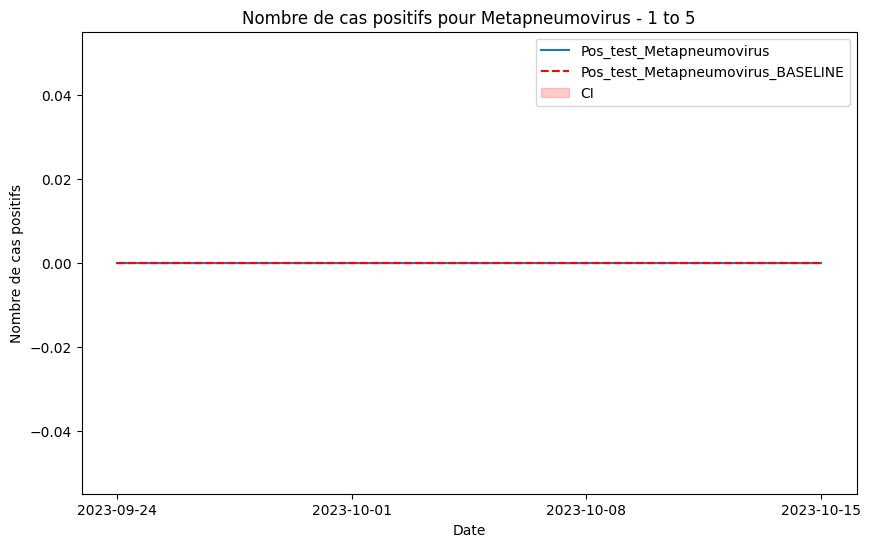

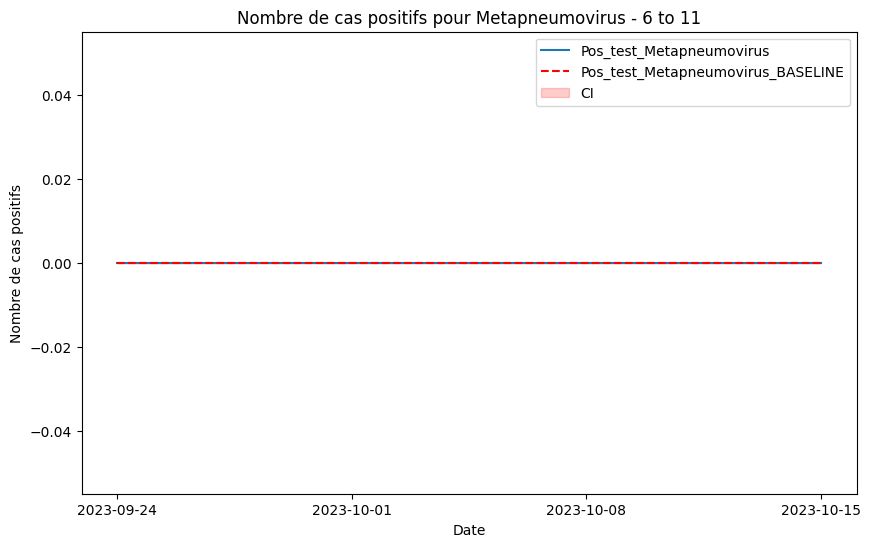

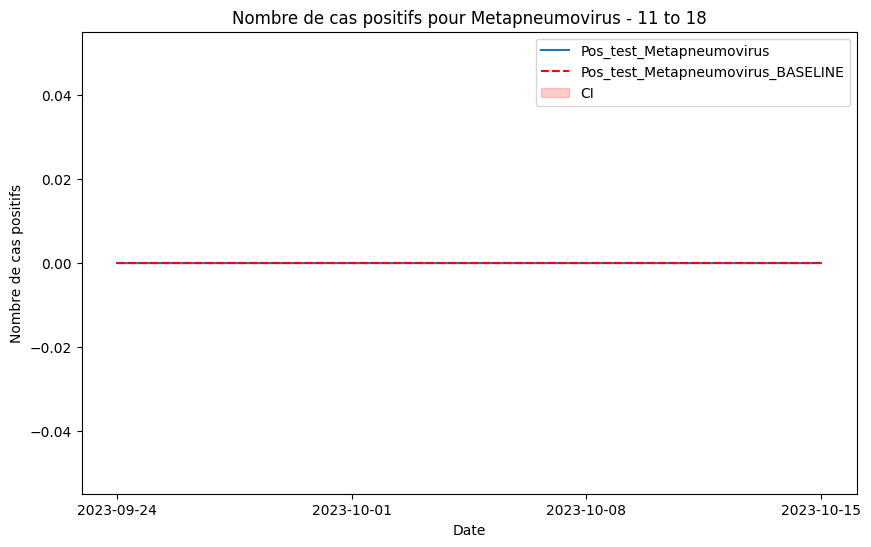

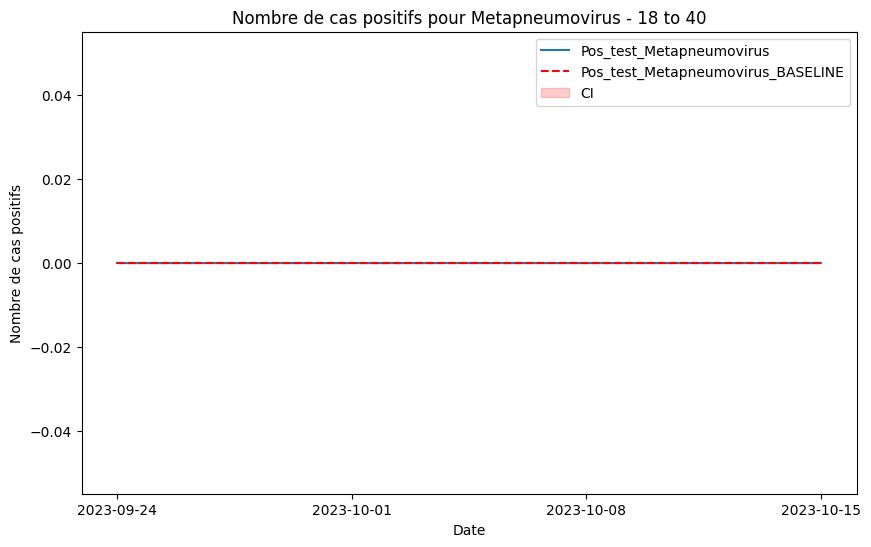

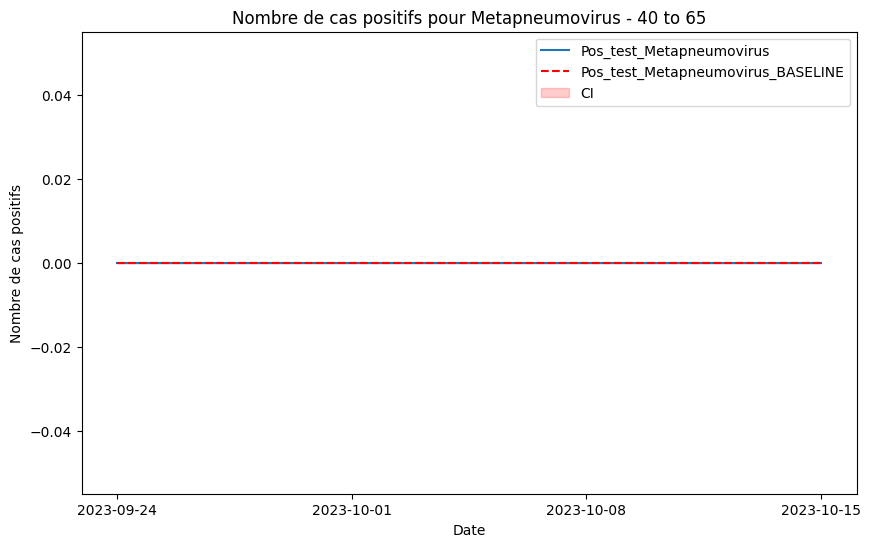

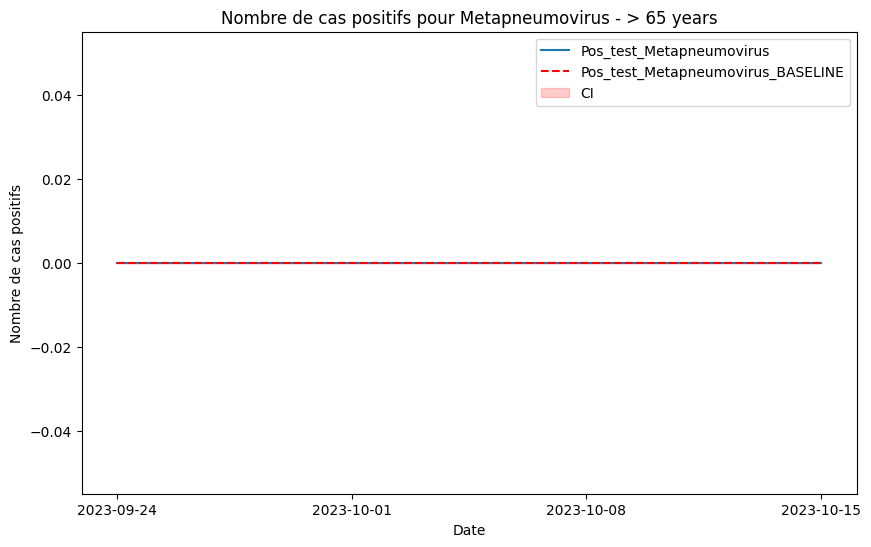

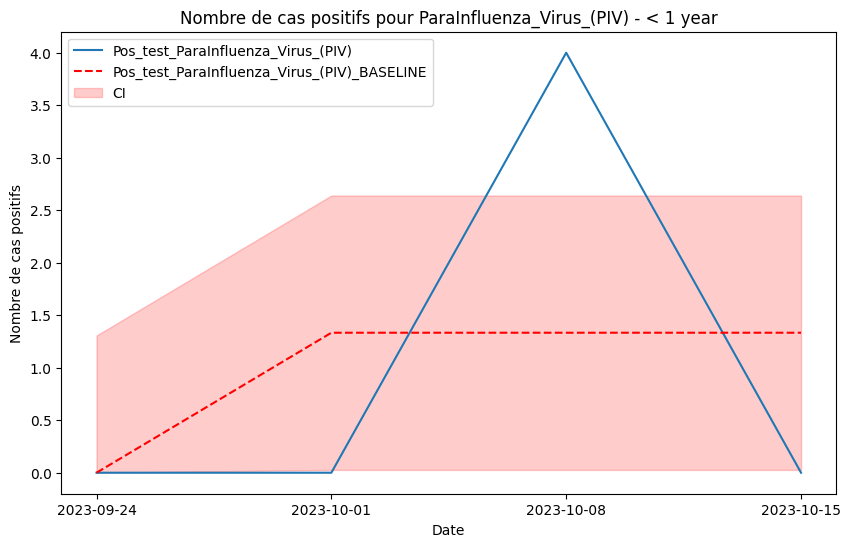

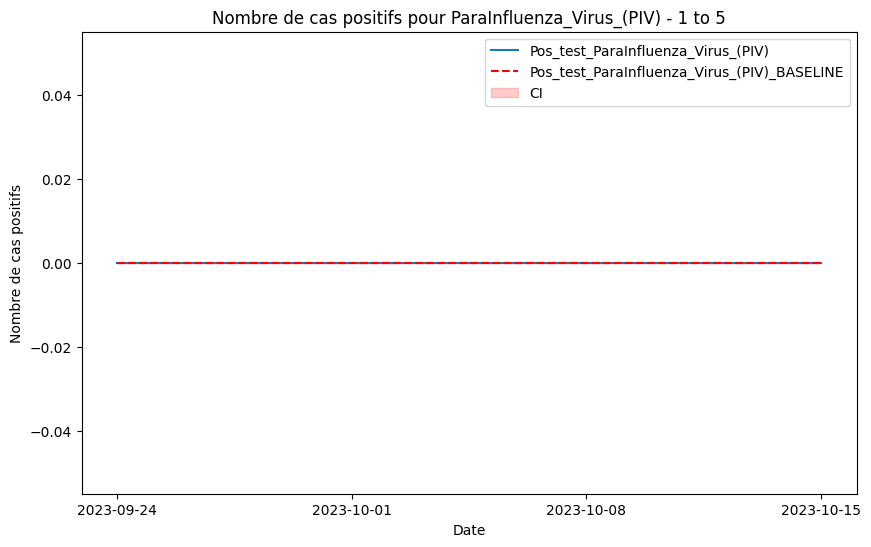

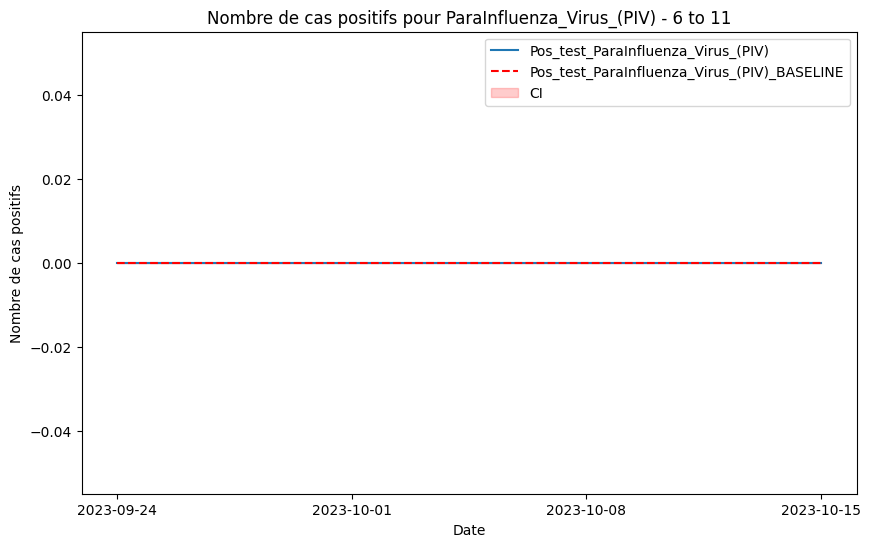

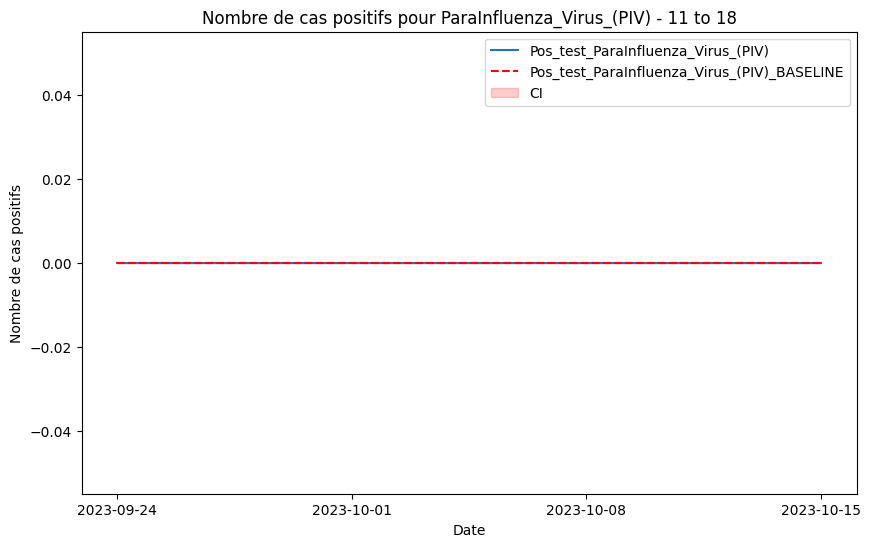

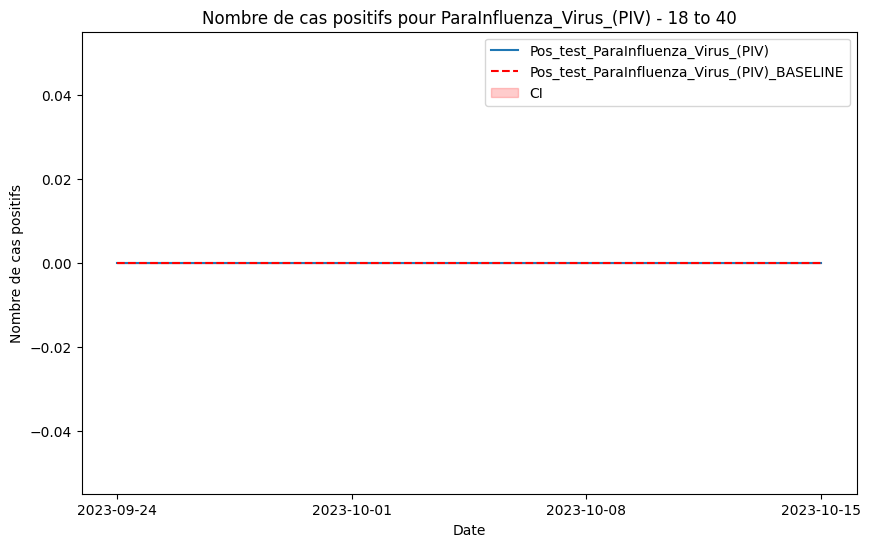

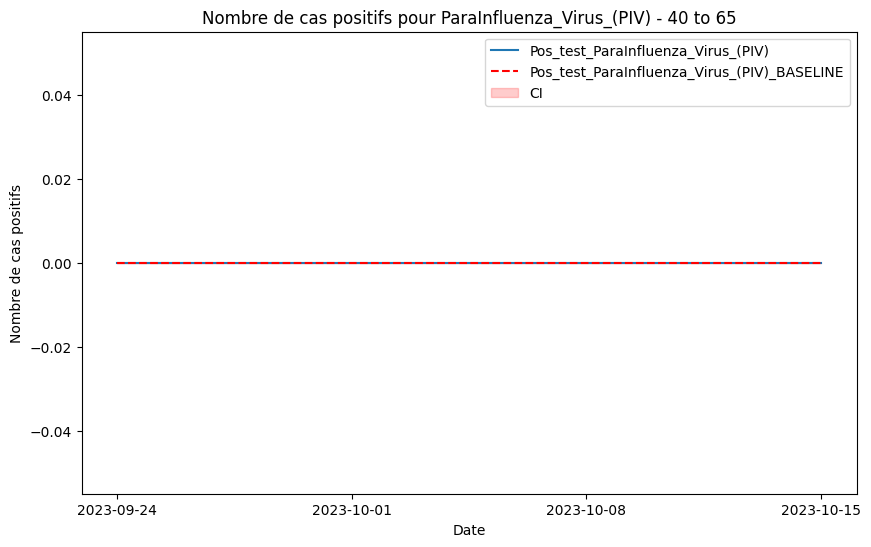

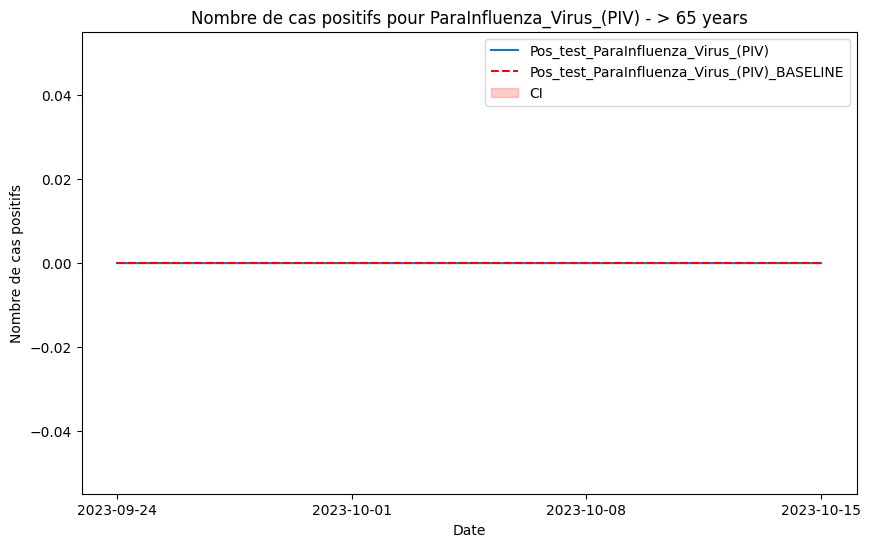

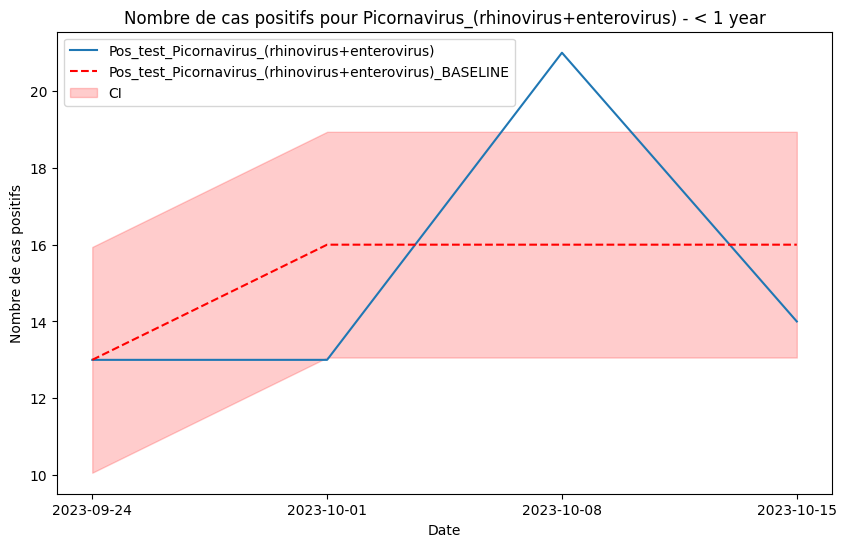

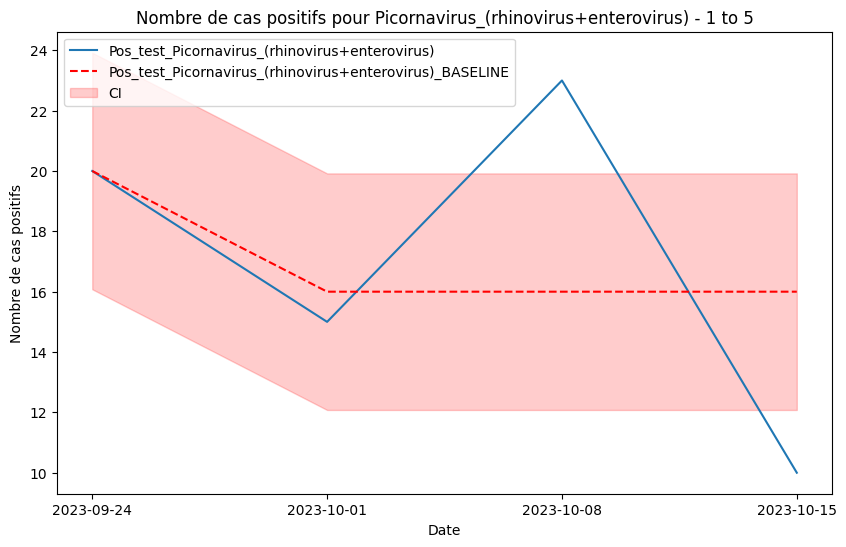

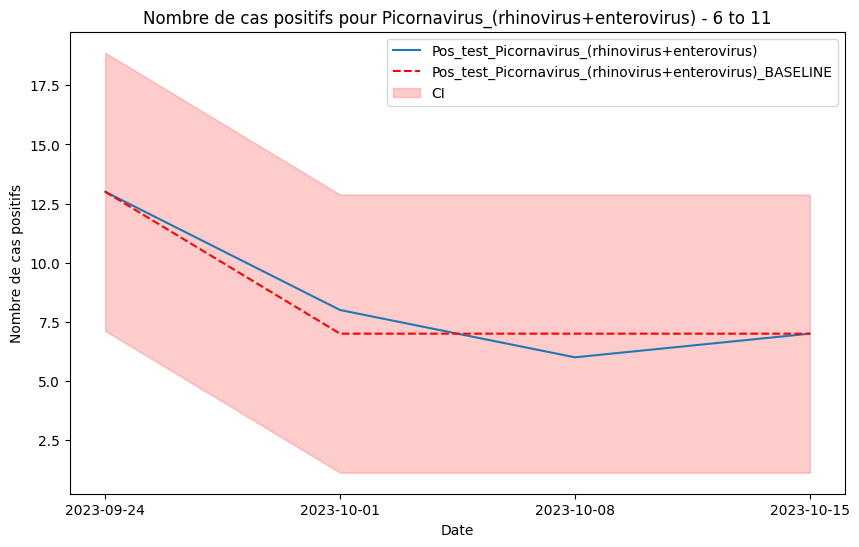

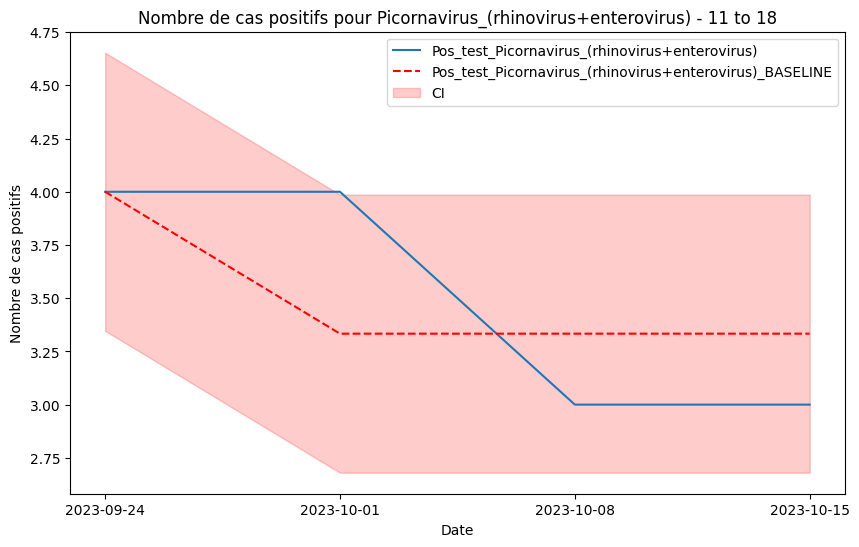

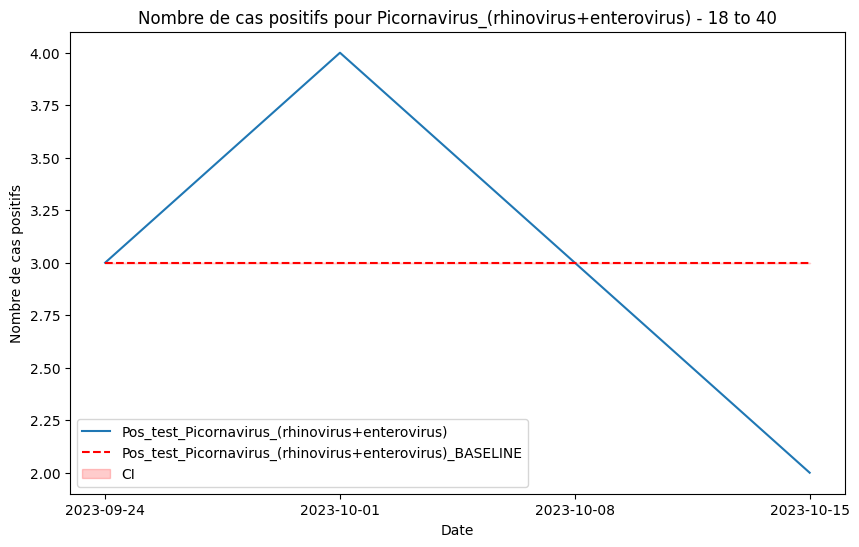

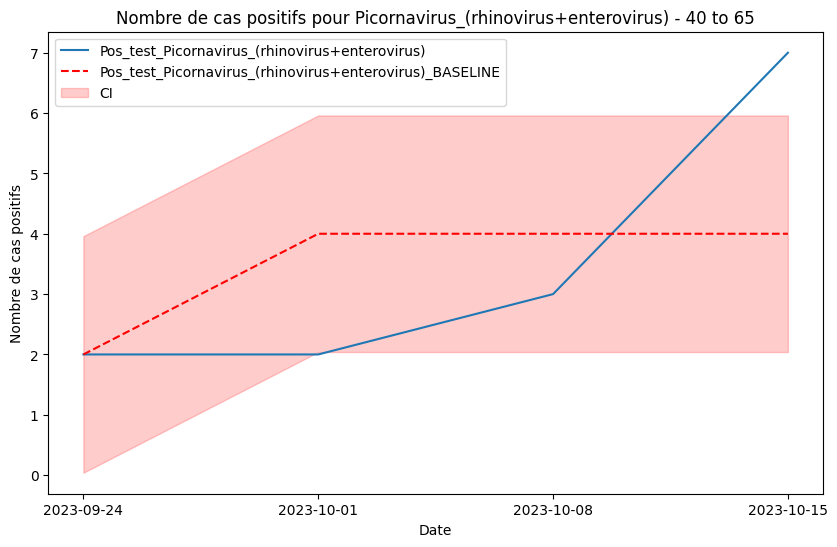

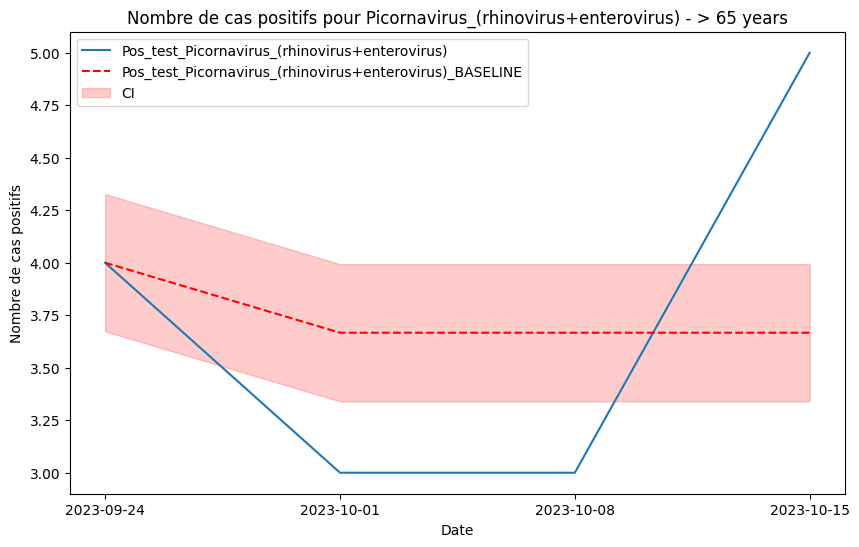

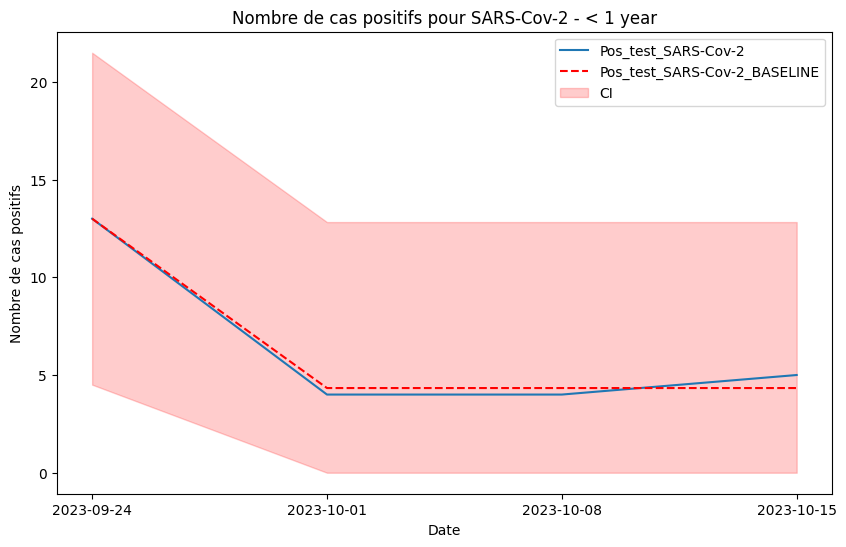

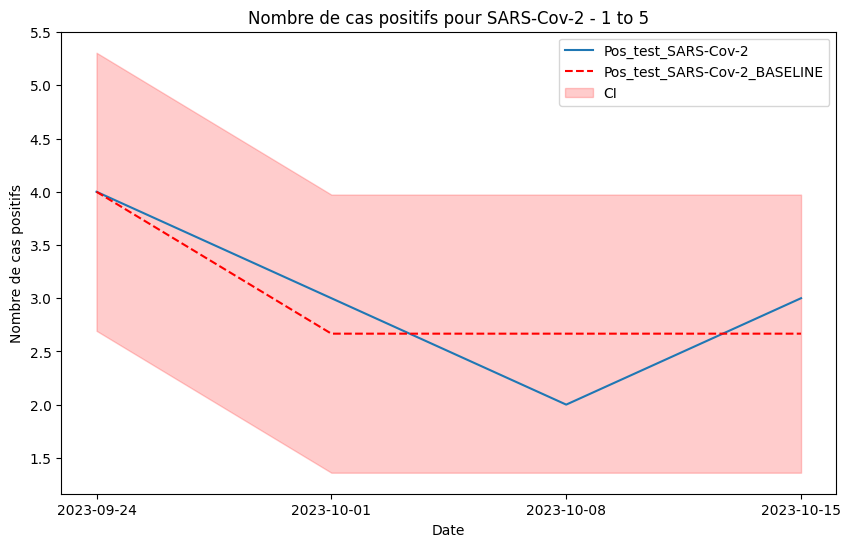

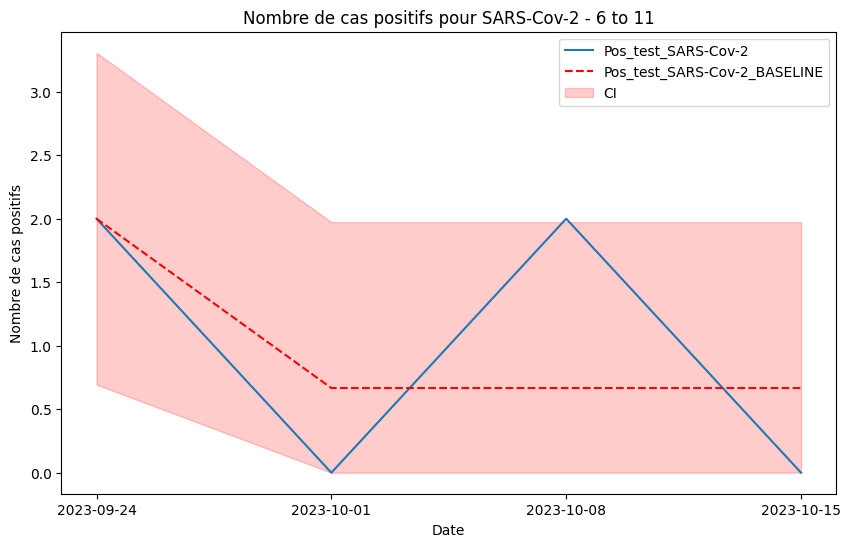

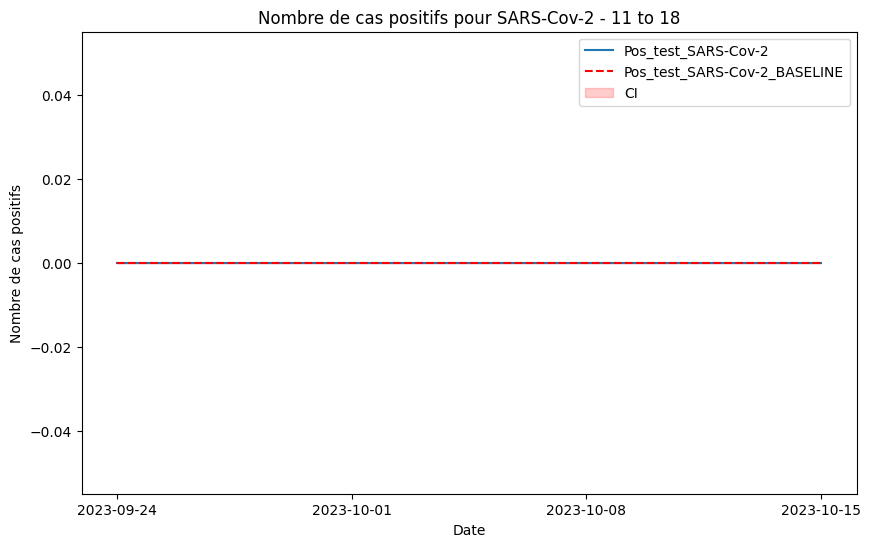

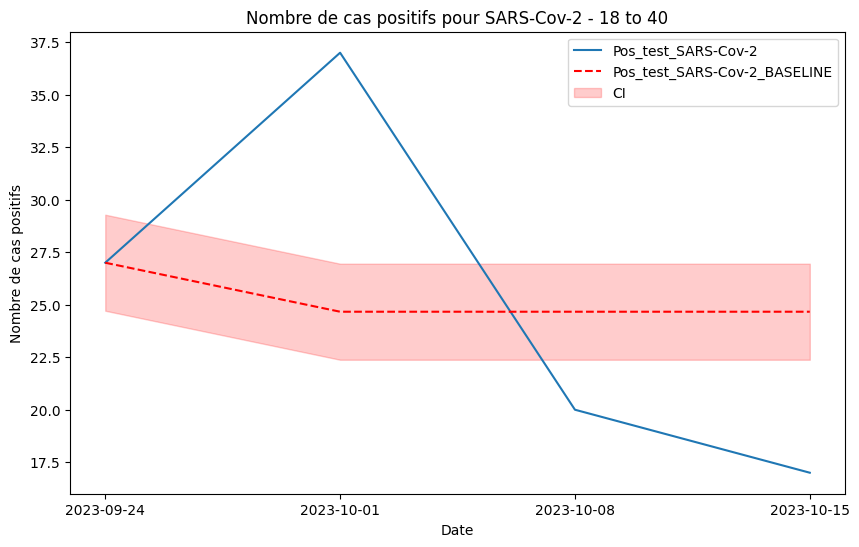

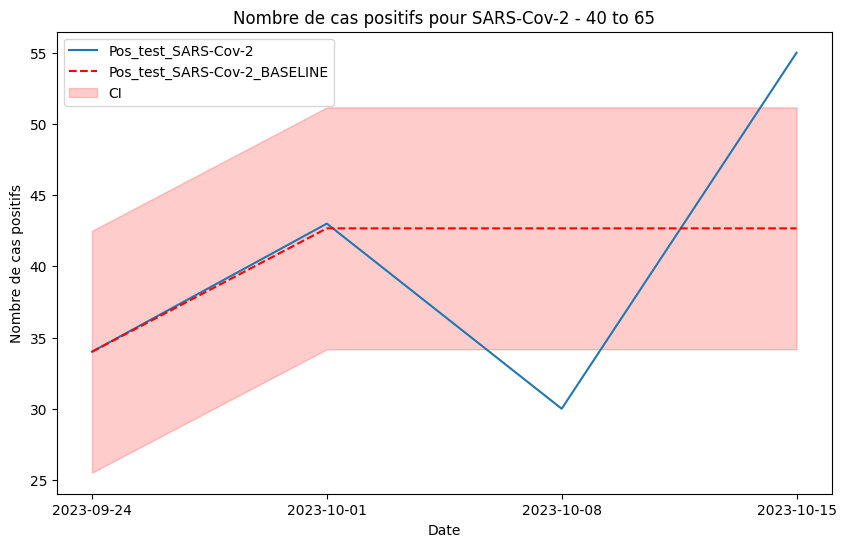

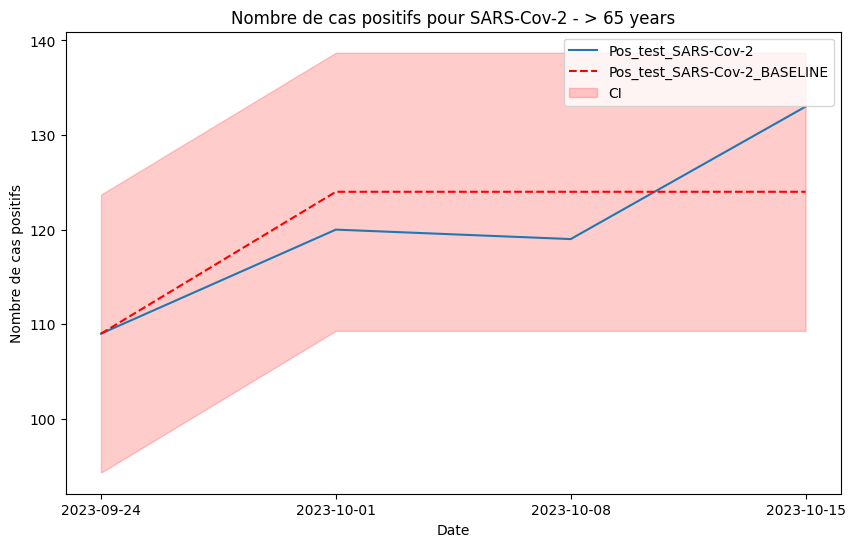

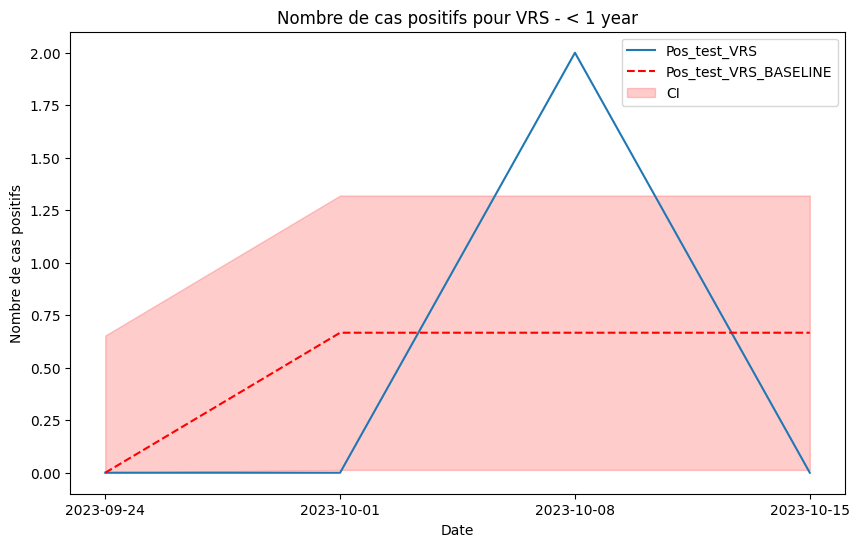

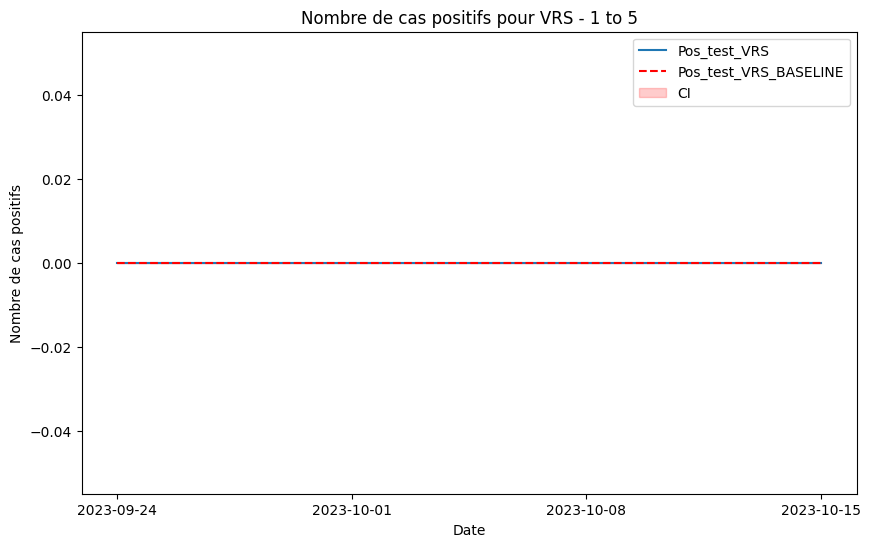

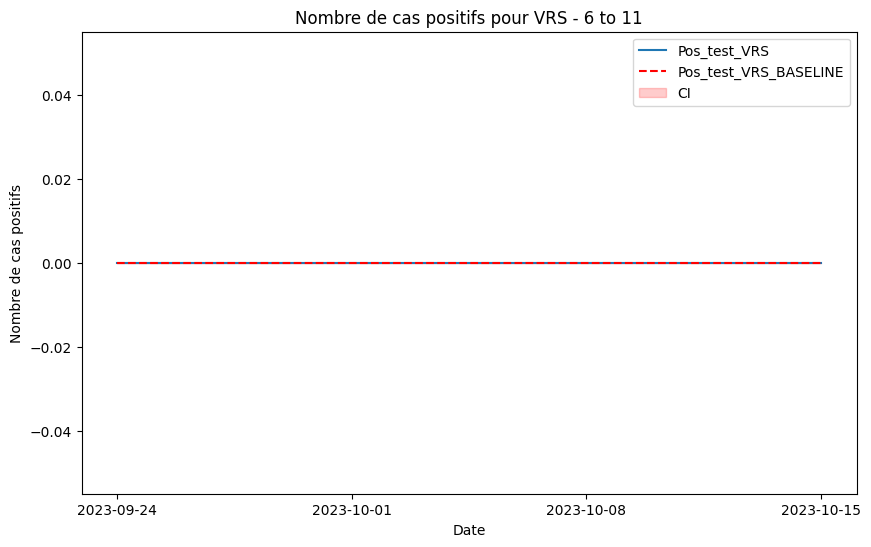

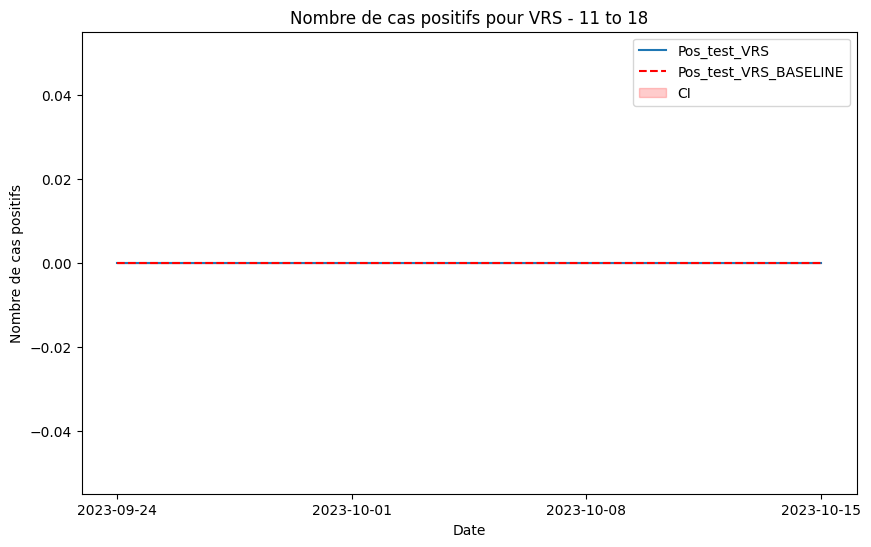

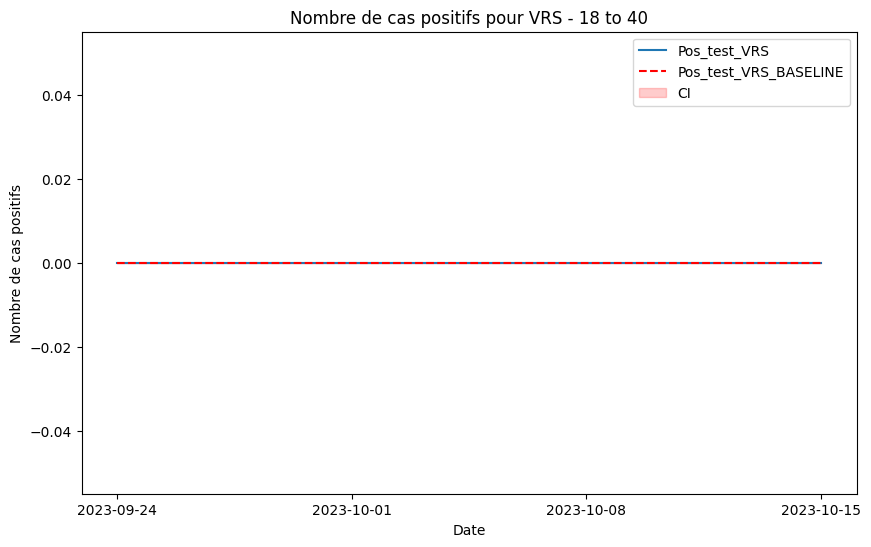

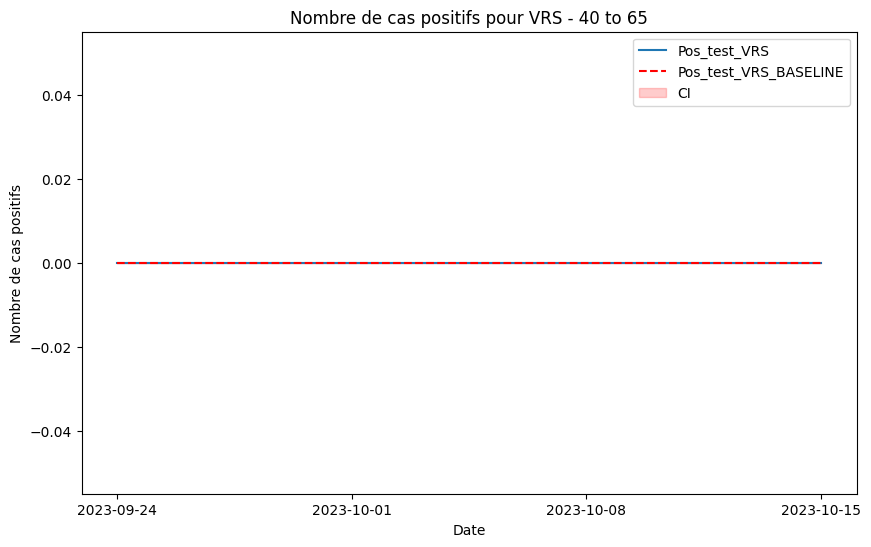

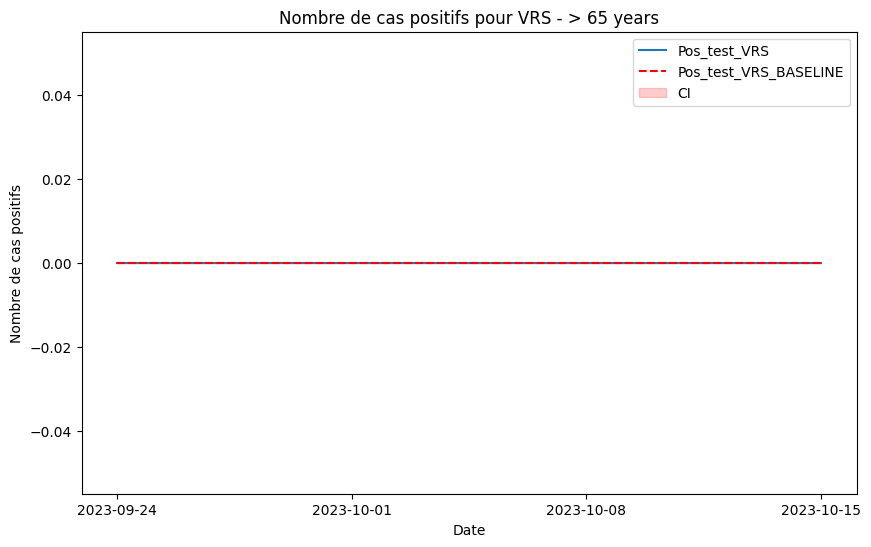

In [97]:
maladies = [col.split("Pos_test_")[1] for col in df.columns if "Pos_test_" in col and "BASELINE" not in col]

# Extraire les classes d'âge depuis la colonne "Age_Class"
classes_age = df["Age_class"].unique()

# Parcours des maladies
for maladie in maladies:
    # Parcours des classes d'âge
    for classe_age in classes_age:


        # Filtrer par classe d'âge
        data_subset = df[df["Age_class"] == classe_age]

        # Tracer le graphique
        plt.figure(figsize=(10, 6))
        sns.lineplot(x="Date", y=f"Pos_test_{maladie}", data=data_subset, label=f"Pos_test_{maladie}")
        sns.lineplot(x="Date", y=f"Pos_test_{maladie}_BASELINE", data=data_subset, label=f"Pos_test_{maladie}_BASELINE", linestyle='dashed', color='red')
        plt.fill_between(data_subset["Date"], data_subset[f"LOWER_CI_Pos_test_{maladie}_BASELINE"], data_subset[f"UPPER_CI_Pos_test_{maladie}_BASELINE"], alpha=0.2, label="CI", color='red')
        plt.title(f"Nombre de cas positifs pour {maladie} - {classe_age}")
        plt.xlabel("Date")
        plt.ylabel("Nombre de cas positifs")
        plt.legend()
        plt.show()